<a href="https://colab.research.google.com/github/Alarmelmangai-K/master-thesis/blob/main/binary_classification_FSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nbstripout
!nbstripout --install


fatal: --local can only be used inside a git repository
Installation failed: not a git repository!


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=73575548d773ad280294f288af1aad7e32aa45975a867f14752e50a8e9452941
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

--2025-09-10 20:51:49--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383874762 (366M) [application/x-gzip]
Saving to: ‘variant_summary.txt.gz’

variant_summary.txt 100%[===================>] 366.09M  36.3MB/s    in 11s     

2025-09-10 20:52:00 (34.9 MB/s) - ‘variant_summary.txt.gz’ saved [383874762/383874762]



In [ ]:
import gzip
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import scipy.special
import re
import warnings
warnings.filterwarnings('ignore')
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif #knn, kmeans
from sklearn.calibration import CalibratedClassifierCV #knn, kmeans
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
file_path = "variant_summary.txt.gz"
columns = ["VariationID", "GeneSymbol", "ClinicalSignificance", "ReviewStatus", "Type"]
df = pd.read_csv(file_path, sep="\t", usecols=columns)
major_classes = ['Pathogenic', 'Benign']
df_binary = df[df['ClinicalSignificance'].isin(major_classes)]

min_count = df_binary['ClinicalSignificance'].value_counts().min()
df_binary_balanced = (
    df_binary.groupby("ClinicalSignificance", group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
)

print(df_binary_balanced['ClinicalSignificance'].value_counts())
print(df_binary_balanced.head())

features = ['GeneSymbol', 'ReviewStatus', 'Type']
X = df_binary[features].fillna("Unknown")
for col in features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

y = df_binary['ClinicalSignificance']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

ClinicalSignificance
Benign        384422
Pathogenic    384422
Name: count, dtype: int64
                              Type GeneSymbol ClinicalSignificance  \
2227413  single nucleotide variant       BRK1               Benign   
4990939  single nucleotide variant     SETBP1               Benign   
322632   single nucleotide variant       PEX1               Benign   
2179899  single nucleotide variant      PPM1D               Benign   
1102369  single nucleotide variant      EIF3B               Benign   

                                              ReviewStatus  VariationID  
2227413                criteria provided, single submitter      1292409  
4990939                criteria provided, single submitter      2779777  
322632   criteria provided, multiple submitters, no con...       256221  
2179899                criteria provided, single submitter      1268529  
1102369                criteria provided, single submitter       768132  


# **TREE MODEL**

# **Random forest**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("=== RandomForest Classification Report ===")
print(classification_report(y_test, y_pred))

=== RandomForest Classification Report ===
              precision    recall  f1-score   support

      Benign       0.85      0.85      0.85     85443
  Pathogenic       0.84      0.84      0.84     76885

    accuracy                           0.85    162328
   macro avg       0.85      0.85      0.85    162328
weighted avg       0.85      0.85      0.85    162328



Feature Importance -rf_model based on Gini

In [ ]:
import pandas as pd
rf_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nRandom Forest feature importances:\n", rf_importances)


Random Forest feature importances:
         Feature  Importance
0    GeneSymbol    0.558232
2          Type    0.306618
1  ReviewStatus    0.135150


Permutation Importance- rf_model

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
print("\nRandom Forest permutation importances:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")


Random Forest permutation importances:

GeneSymbol: 0.2301
ReviewStatus: 0.0944
Type: 0.1267


Shap (Summary- Global Importance) Mean_Absolute_SHAP - rf_model

In [ ]:
sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

In [ ]:
  if isinstance(shap_values_rf, list) and len(shap_values_rf) == 2:
      shap_values_rf_class1 = shap_values_rf[1]
  else:
      shap_values_rf_class1 = shap_values_rf
  shap_values_class1_fixed = shap_values_rf_class1[:, :, 1]
  mean_abs_shap = np.abs(shap_values_class1_fixed).mean(axis=0)
feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Mean_Absolute_SHAP": mean_abs_shap
}).sort_values(by="Mean_Absolute_SHAP", ascending=False)

print("Random Forest Mean absolute SHAP values (Feature Importance):")
print(feature_importance_df)

Random Forest Mean absolute SHAP values (Feature Importance):
        Feature  Mean_Absolute_SHAP
0    GeneSymbol            0.206827
2          Type            0.161082
1  ReviewStatus            0.086489


LIME- Mean Feature Importance Summary- rf_model

In [ ]:
explainer_rf = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns.tolist(),
    class_names=['Benign', 'Pathogenic'],
    mode='classification'
)
n_samples = 100
feature_weights = {}
for i in range(n_samples):
    exp = explainer_rf.explain_instance(
        data_row=X.iloc[i].values,
        predict_fn=rf_model.predict_proba
    )
    for feature, weight in exp.as_list():
        base_feature = feature.split()[0]
        if not base_feature.replace('.', '', 1).isdigit():
            feature_weights.setdefault(base_feature, []).append(weight)
mean_importance = {
    feature: np.mean(weights) for feature, weights in feature_weights.items()
}
importance_df = pd.DataFrame.from_dict(
    mean_importance, orient='index', columns=['Mean_Weight']
).sort_values(by='Mean_Weight', ascending=False)
print("\nRandom Forest Aggregated LIME Feature Importance:\n")
print(importance_df)


Random Forest Aggregated LIME Feature Importance:

              Mean_Weight
Type             0.086290
ReviewStatus     0.061146
GeneSymbol       0.038384


# **XGBoost**

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=500, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
print("=== GradientBoosting Classification Report ===")
print(classification_report(y_test, y_pred_gb))

=== GradientBoosting Classification Report ===
              precision    recall  f1-score   support

      Benign       0.76      0.83      0.80     85443
  Pathogenic       0.79      0.71      0.75     76885

    accuracy                           0.78    162328
   macro avg       0.78      0.77      0.77    162328
weighted avg       0.78      0.78      0.77    162328



Feature Importance - gb_model based on Gain

In [ ]:
gb_importances = pd.DataFrame({
    'Feature': features,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nXGBoost feature importances:\n", gb_importances)


XGBoost feature importances:
         Feature  Importance
2          Type    0.586878
0    GeneSymbol    0.244839
1  ReviewStatus    0.168283


Permutation importance - gb_model

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(gb_model, X_test, y_test, n_repeats=10, random_state=42)
print("\nXGBoost permutation importances:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")


XGBoost permutation importances:

GeneSymbol: 0.0685
ReviewStatus: 0.0526
Type: 0.1678


Shap (Summary- Global Importance) Mean_Absolute_SHAP - gb_model

In [ ]:
sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)
explainer_gb = shap.TreeExplainer(gb_model)
shap_values_gb = explainer_gb.shap_values(X_test_sample)
if isinstance(shap_values_gb, list) and len(shap_values_gb) == 2:
    shap_values_class1 = shap_values_gb[1]
else:
    shap_values_class1 = shap_values_gb
shap_values_class1_fixed = shap_values_class1[:, :, 1]
mean_abs_shap = np.abs(shap_values_class1_fixed).mean(axis=0)
mean_shap_df = pd.DataFrame({
    'Feature': features,
    'Mean_Absolute_SHAP': mean_abs_shap
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)
print("\nXGBoost Mean_Absolute_SHAP:\n")
print(mean_shap_df)


XGBoost Mean_Absolute_SHAP:

        Feature  Mean_Absolute_SHAP
2          Type            0.924946
0    GeneSymbol            0.513101
1  ReviewStatus            0.407556


LIME - Mean Feature Importance Summary- gb_model

In [ ]:
aggregated_weights = {}
for feature_interval, weights in feature_weights.items():
    base_feature = feature_interval.split()[0]
    if not base_feature.replace('.', '', 1).isdigit():
        aggregated_weights.setdefault(base_feature, []).extend(weights)
mean_aggregated = {
    feature: np.mean(weights) for feature, weights in aggregated_weights.items()
}
aggregated_df = pd.DataFrame.from_dict(
    mean_aggregated, orient='index', columns=['Mean_Weight']
).sort_values(by='Mean_Weight', ascending=False)
print("\n XGBoost Aggregated LIME Feature Importance:\n")
print(aggregated_df)


 XGBoost Aggregated LIME Feature Importance:

              Mean_Weight
Type             0.086290
ReviewStatus     0.061146
GeneSymbol       0.038384


## **Decision Tree**

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("=== Decision Tree Classification Report ===")
print(classification_report(y_test, y_pred_dt))

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

      Benign       0.85      0.86      0.85     85443
  Pathogenic       0.84      0.83      0.84     76885

    accuracy                           0.85    162328
   macro avg       0.85      0.85      0.85    162328
weighted avg       0.85      0.85      0.85    162328



Feature importance -dt_model

In [ ]:
dt_importances = pd.DataFrame({"Feature": features,
                               "Importance": dt_model.feature_importances_
                               }).sort_values(by="Importance", ascending=False)
print("\nDecision Tree Feature Importance:\n", dt_importances)


Decision Tree Feature Importance:
         Feature  Importance
0    GeneSymbol    0.542464
2          Type    0.351996
1  ReviewStatus    0.105540


Permutation Importance- dt_model

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(dt_model, X_test, y_test, n_repeats=10, random_state=42)
print("\nDecision Tree Permutation Importance:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")


Decision Tree Permutation Importance:

GeneSymbol: 0.2302
ReviewStatus: 0.0926
Type: 0.1316


 Shap (Summary- Global Importance) Mean_Absolute_SHAP -dt_model

In [ ]:
import shap
import numpy as np
import pandas as pd
sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)
explainer_dt = shap.TreeExplainer(dt_model)
shap_values_dt = explainer_dt.shap_values(X_test_sample)
if isinstance(shap_values_dt, list) and len(shap_values_dt) == 2:
    shap_values_class1 = shap_values_dt[1]
else:
    shap_values_class1 = shap_values_dt
if shap_values_class1.ndim == 3:
    shap_values_class1 = shap_values_class1[:, :, 0]
mean_abs_shap = np.mean(np.abs(shap_values_class1), axis=0)
mean_abs_shap = mean_abs_shap.flatten()
feature_names = X_test_sample.columns[:len(mean_abs_shap)]
mean_shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Absolute_SHAP': mean_abs_shap
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)
print("\nDecision Tree Mean Absolute SHAP Values:\n")
print(mean_shap_df)


Decision Tree Mean Absolute SHAP Values:

        Feature  Mean_Absolute_SHAP
0    GeneSymbol            0.207120
2          Type            0.176082
1  ReviewStatus            0.076996


LIME - Mean Feature Importance Summary- dt_model

In [ ]:
explainer_dt = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns.tolist(),
    class_names=['Benign', 'Pathogenic'],
    mode='classification'
)
n_samples = 100
feature_weights = {}
for i in range(n_samples):
    exp = explainer_dt.explain_instance(
        data_row=X.iloc[i].values,
        predict_fn=dt_model.predict_proba
    )
    for feature, weight in exp.as_list():
        base_feature = feature.split()[0]
        if not base_feature.replace('.', '', 1).isdigit():
            feature_weights.setdefault(base_feature, []).append(weight)
mean_importance = {
    feature: np.mean(weights) for feature, weights in feature_weights.items()
}
importance_df = pd.DataFrame.from_dict(
    mean_importance, orient='index', columns=['Mean_Weight']
).sort_values(by='Mean_Weight', ascending=False)
print("\n Decision Tree Aggregated LIME Feature Importance:\n")
print(importance_df)


 Decision Tree Aggregated LIME Feature Importance:

              Mean_Weight
ReviewStatus     0.032891
GeneSymbol       0.032312
Type            -0.069145


# **CAT**

In [ ]:
cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
print("=== CatBoost Classification Report ===")
print(classification_report(y_test, y_pred_cat))

=== CatBoost Classification Report ===
              precision    recall  f1-score   support

      Benign       0.75      0.84      0.80     85443
  Pathogenic       0.80      0.69      0.74     76885

    accuracy                           0.77    162328
   macro avg       0.78      0.77      0.77    162328
weighted avg       0.77      0.77      0.77    162328



Featute importance- cat_model

In [ ]:
cat_importances = pd.DataFrame({"Feature": features,
                               "Importance": cat_model.feature_importances_
                               }).sort_values(by="Importance", ascending=False)
print("\nCategorical Boosting(CAT) Feature Importance:\n", cat_importances)


Categorical Boosting(CAT) Feature Importance:
         Feature  Importance
0    GeneSymbol   55.936935
1  ReviewStatus   24.714655
2          Type   19.348410


Permutation importance- cat_model

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(cat_model, X_test, y_test, n_repeats=10, random_state=42)
print("\nCategorical Boosting(CAT) Permutation Importance:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")


Categorical Boosting(CAT) Permutation Importance:

GeneSymbol: 0.0670
ReviewStatus: 0.0596
Type: 0.1791


 Shap (Summary- Global Importance) Mean_Absolute_SHAP -cat_model


In [ ]:
sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

explainer_cat = shap.TreeExplainer(cat_model)
shap_values_cat = explainer_cat.shap_values(X_test_sample)

if isinstance(shap_values_cat, list) and len(shap_values_cat) == 2:
    shap_values_class1 = shap_values_cat[1]
else:
    shap_values_class1 = shap_values_cat

mean_abs_shap = np.mean(np.abs(shap_values_class1), axis=0)

mean_shap_df = pd.DataFrame({
    'Feature': X_test_sample.columns[:len(mean_abs_shap)],
    'Mean_Absolute_SHAP': mean_abs_shap
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)

print("\nCATBOOST Mean Absolute SHAP Values:\n")
print(mean_shap_df)


CATBOOST Mean Absolute SHAP Values:

        Feature  Mean_Absolute_SHAP
2          Type            1.032437
0    GeneSymbol            0.618186
1  ReviewStatus            0.463484


LIME - Mean Feature Importance Summary- cat_model

In [ ]:
explainer_cat = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns.tolist(),
    class_names=['Benign', 'Pathogenic'],
    mode='classification'
)
n_samples = 100
feature_weights = {}

for i in range(n_samples):
    exp = explainer_cat.explain_instance(
        data_row=X.iloc[i].values,
        predict_fn=cat_model.predict_proba
    )
    for feature, weight in exp.as_list():
        base_feature = feature.split()[0]
        if not base_feature.replace('.', '', 1).isdigit():
            feature_weights.setdefault(base_feature, []).append(weight)
mean_importance = {
    feature: np.mean(weights) for feature, weights in feature_weights.items()
}
importance_df = pd.DataFrame.from_dict(
    mean_importance, orient='index', columns=['Mean_Weight']
).sort_values(by='Mean_Weight', ascending=False)

print("\n CATBOOST Aggregated LIME Feature Importance:\n")
print(importance_df)


 CATBOOST Aggregated LIME Feature Importance:

              Mean_Weight
Type             0.232576
ReviewStatus     0.021319
GeneSymbol       0.019516


# **LightGBM**

In [ ]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
print("=== LightGBM Classification Report ===")
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 307537, number of negative: 341771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 649308, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473638 -> initscore=-0.105546
[LightGBM] [Info] Start training from score -0.105546
=== LightGBM Classification Report ===
              precision    recall  f1-score   support

      Benign       0.75      0.83      0.79     85443
  Pathogenic       0.79      0.68      0.73     76885

    accuracy                           0.76    162328
   macro avg       0.77      0.76      0.76    162328
weighted avg       0.77      0.76      0.76    162328



Feature importance- lgbm_model

In [ ]:
lgbm_importances = pd.DataFrame({"Feature": features,
                               "Importance": lgbm_model.feature_importances_
                               }).sort_values(by="Importance", ascending=False)
print("\n LightGBM Feature Importance:\n", lgbm_importances)


 LightGBM Feature Importance:
         Feature  Importance
0    GeneSymbol        2222
1  ReviewStatus         428
2          Type         350


Permutation Importance -lgbm_model

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(lgbm_model, X_test, y_test, n_repeats=10, random_state=42)
print("\nLightGBM  Permutation Importance:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")


LightGBM  Permutation Importance:

GeneSymbol: 0.0472
ReviewStatus: 0.0563
Type: 0.1816


SHAP - lgbm_model

In [ ]:
sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)
explainer_lgbm = shap.TreeExplainer(lgbm_model)
shap_values_lgbm = explainer_lgbm.shap_values(X_test_sample)
if isinstance(shap_values_lgbm, list) and len(shap_values_lgbm) == 2:
    shap_values_class1 = shap_values_lgbm[1]
else:
    shap_values_class1 = shap_values_lgbm
mean_abs_shap = np.mean(np.abs(shap_values_class1), axis=0)
mean_shap_df = pd.DataFrame({
    'Feature': X_test_sample.columns[:len(mean_abs_shap)],
    'Mean_Absolute_SHAP': mean_abs_shap
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)
print("\nLightGBM Mean Absolute SHAP Values:\n")
print(mean_shap_df)


LightGBM Mean Absolute SHAP Values:

        Feature  Mean_Absolute_SHAP
2          Type            0.999341
1  ReviewStatus            0.419215
0    GeneSymbol            0.404847


LIME - Mean Feature Importance Summary- lgbm_model

In [ ]:
explainer_lgbm = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns.tolist(),
    class_names=['Benign', 'Pathogenic'],
    mode='classification'
)
n_samples = 100
feature_weights = {}
for i in range(n_samples):
    exp = explainer_lgbm.explain_instance(
        data_row=X.iloc[i].values,
        predict_fn=lgbm_model.predict_proba
    )
    for feature, weight in exp.as_list():
        base_feature = feature.split()[0]
        if not base_feature.replace('.', '', 1).isdigit():
            feature_weights.setdefault(base_feature, []).append(weight)
mean_importance = {
    feature: np.mean(weights) for feature, weights in feature_weights.items()
}
importance_df = pd.DataFrame.from_dict(
    mean_importance, orient='index', columns=['Mean_Weight']
).sort_values(by='Mean_Weight', ascending=False)
print("\n LightGBM Aggregated LIME Feature Importance:\n")
print(importance_df)


 LightGBM Aggregated LIME Feature Importance:

              Mean_Weight
Type             0.170817
GeneSymbol       0.019661
ReviewStatus    -0.004741


# **LINEAR MODEL**

# **Logistic Regression**

In [ ]:
lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("=== LogisticRegression Classification Report ===")
print(classification_report(y_test, y_pred_lr))

=== LogisticRegression Classification Report ===
              precision    recall  f1-score   support

      Benign       0.72      0.82      0.76     85443
  Pathogenic       0.76      0.64      0.70     76885

    accuracy                           0.73    162328
   macro avg       0.74      0.73      0.73    162328
weighted avg       0.74      0.73      0.73    162328



Co-efficient Importance and intercept - lr_model

In [ ]:
coef_df = pd.DataFrame(lr_model.coef_, columns=features)
coef_df.index = ['Class 1 vs Class 0']
print("Logistic Regression- Feature coefficients per class:\n", coef_df)
print("\n Logistic Regression- Intercept per class  :\n", lr_model.intercept_)

Logistic Regression- Feature coefficients per class:
                     GeneSymbol  ReviewStatus      Type
Class 1 vs Class 0    0.000008      0.712557 -0.180998

 Logistic Regression- Intercept per class  :
 [0.93313826]


Permutation Importance- lr_model

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(lr_model, X_test, y_test, n_repeats=10, random_state=42)
print("\n Logistic Regression- Permutation Importance:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")



 Logistic Regression- Permutation Importance:

GeneSymbol: -0.0000
ReviewStatus: 0.0518
Type: 0.1809


SHAP- Mean_Absolute_SHAP -lr_model

In [ ]:
masker = shap.maskers.Independent(X_train)
explainer_lr = shap.LinearExplainer(lr_model, masker=masker)

shap_values_lr = explainer_lr(X_test)
mean_abs_shap = np.mean(np.abs(shap_values_lr.values), axis=0)

mean_shap_df = pd.DataFrame({
    'Feature': features,
    'Mean_Absolute_SHAP': mean_abs_shap
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)
print("\n Logistic Regression- Mean Absolute SHAP Values:\n")
print(mean_shap_df)


 Logistic Regression- Mean Absolute SHAP Values:

        Feature  Mean_Absolute_SHAP
2          Type            0.873480
1  ReviewStatus            0.365598
0    GeneSymbol            0.030734


LIME Aggregated Feature Importance- lr_model

In [ ]:
categorical_indices = [features.index('Type'), features.index('ReviewStatus'), features.index('GeneSymbol')]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Benign', 'Pathogenic'],
    categorical_features=categorical_indices,
    mode='classification'
)

num_instances = 10
instances = X_test.sample(num_instances, random_state=42)
all_weights = []

for i in range(num_instances):
    exp = explainer.explain_instance(
        data_row=instances.iloc[i].values,
        predict_fn=lr_model.predict_proba,
        num_features=len(features)
    )
    weights_dict = dict(exp.as_list())
    all_weights.append(weights_dict)

weights_df = pd.DataFrame(all_weights).fillna(0)

# For each categorical feature, sum importance over their related rules (thresholds)
def aggregate_categorical_feature_importance(weights_df, categorical_feature_names):
    agg_weights = {}
    for feature_name in categorical_feature_names:
        mask = weights_df.columns.str.contains(feature_name)
        agg_weights[feature_name] = weights_df.loc[:, mask].abs().mean().sum()
    return pd.Series(agg_weights).sort_values(ascending=False)

categorical_feature_names = ['Type', 'ReviewStatus', 'GeneSymbol']
feature_importance_summary = aggregate_categorical_feature_importance(weights_df, categorical_feature_names)
print("\n Logistic Regression- Aggregated LIME Feature Importance:\n")
print(feature_importance_summary)



 Logistic Regression- Aggregated LIME Feature Importance:

Type            0.321416
ReviewStatus    0.123837
GeneSymbol      0.037564
dtype: float64


# **SVM**

In [ ]:
model_linear_svc = LinearSVC()
model_linear_svc.fit(X_train, y_train)
y_pred_svc = model_linear_svc.predict(X_test)
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svc))

=== SVM Classification Report ===
              precision    recall  f1-score   support

      Benign       0.72      0.82      0.76     85443
  Pathogenic       0.76      0.64      0.69     76885

    accuracy                           0.73    162328
   macro avg       0.74      0.73      0.73    162328
weighted avg       0.74      0.73      0.73    162328



Co-efficient Importance and intercept - model_linear_scv

In [ ]:
coef_df = pd.DataFrame(model_linear_svc.coef_, columns=features)
coef_df.index = ['Class 1 vs Class 0']
print("\nLinear SVC- Feature coefficients per class:\n", coef_df)
print("\nLinear SVC- Intercept per class  :\n", model_linear_svc.intercept_)


Linear SVC- Feature coefficients per class:
                     GeneSymbol  ReviewStatus      Type
Class 1 vs Class 0    0.000008       0.33041 -0.073666

Linear SVC- Intercept per class  :
 [0.28154797]


Permutation Importance - model_linear_scv

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(model_linear_svc, X_test, y_test, n_repeats=10, random_state=42)
print("\n Linear SVC Permutation Importance:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")


 Linear SVC Permutation Importance:

GeneSymbol: 0.0034
ReviewStatus: 0.0447
Type: 0.1835


SHAP - Mean Absolute SHAP- model_linear_svc

In [ ]:
masker = shap.maskers.Independent(X_train)
explainer_svc = shap.LinearExplainer(model_linear_svc, masker=masker)
shap_values_svc = explainer_svc(X_test)
mean_abs_shap = np.abs(shap_values_svc.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    "Feature": features,
    "Mean_Absolute_SHAP": mean_abs_shap
}).sort_values(by="Mean_Absolute_SHAP", ascending=False)
print("\n Linear SVC Feature Importance (mean absolute SHAP values):")
print(shap_importance_df)


 Linear SVC Feature Importance (mean absolute SHAP values):
        Feature  Mean_Absolute_SHAP
2          Type            0.355506
1  ReviewStatus            0.169527
0    GeneSymbol            0.030948


LIME- Aggregated Feature Importance -model_linear_svc

In [ ]:
categorical_indices = [features.index('Type'), features.index('ReviewStatus'), features.index('GeneSymbol')]
calibrated_svc = CalibratedClassifierCV(model_linear_svc, method='isotonic', cv=5)
calibrated_svc.fit(X_train, y_train)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Benign', 'Pathogenic'],
    categorical_features=categorical_indices,
    mode='classification'
)

num_instances = 10
instances = X_test.sample(num_instances, random_state=42)
all_weights = []

for i in range(num_instances):
    exp = explainer.explain_instance(
        data_row=instances.iloc[i].values,
        predict_fn=calibrated_svc.predict_proba,
        num_features=len(features)
    )
    weights_dict = dict(exp.as_list())
    all_weights.append(weights_dict)

weights_df = pd.DataFrame(all_weights).fillna(0)
def aggregate_categorical_feature_importance(weights_df, categorical_feature_names):
    agg_weights = {}
    for feature_name in categorical_feature_names:
        mask = weights_df.columns.str.contains(feature_name)
        agg_weights[feature_name] = weights_df.loc[:, mask].abs().mean().sum()
    return pd.Series(agg_weights).sort_values(ascending=False)

categorical_feature_names = ['Type', 'ReviewStatus', 'GeneSymbol']
feature_importance_summary = aggregate_categorical_feature_importance(weights_df, categorical_feature_names)
print("\n Linear SVC-Aggregated LIME Feature Importance:\n ")
print(feature_importance_summary)



 Linear SVC-Aggregated LIME Feature Importance:
 
Type            0.322385
ReviewStatus    0.170558
GeneSymbol      0.027170
dtype: float64


# **Naive Bayes**

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb))

=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

      Benign       0.71      0.82      0.76     85443
  Pathogenic       0.76      0.64      0.69     76885

    accuracy                           0.73    162328
   macro avg       0.74      0.73      0.73    162328
weighted avg       0.74      0.73      0.73    162328



In [ ]:
means = pd.DataFrame(nb_model.theta_, columns=features)
means.index = [f"Class {c}" for c in nb_model.classes_]
print("Naives Bayes Feature means per class:\n", means)
variances = pd.DataFrame(nb_model.var_, columns=features)
variances.index = [f"Class {c}" for c in nb_model.classes_]
print("\n Naive Bayes Feature variances per class:\n", variances)

Naives Bayes Feature means per class:
                    GeneSymbol  ReviewStatus       Type
Class Benign      6864.840615      0.656709  11.553470
Class Pathogenic  6856.865945      1.123683   6.850239

 Naive Bayes Feature variances per class:
                     GeneSymbol  ReviewStatus       Type
Class Benign      1.690783e+07      0.487363  13.152458
Class Pathogenic  1.904763e+07      0.719673  31.248932


In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(nb_model, X_test, y_test, n_repeats=10, random_state=42)
print("\nNaives Bayes Permutation Importance:\n")
for i, val in enumerate(result.importances_mean):
    print(f"{features[i]}: {val:.4f}")


Naives Bayes Permutation Importance:

GeneSymbol: -0.0003
ReviewStatus: 0.0479
Type: 0.1818


In [ ]:
sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)
explainer_nb = shap.KernelExplainer(nb_model.predict_proba, X_train)
shap_values_nb = explainer_nb.shap_values(X_test_sample)
mean_shap_df = pd.DataFrame({
    'Feature': features,
    'Mean_Absolute_SHAP': mean_abs_shap
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)
print("\nNaives Bayes- Mean Absolute SHAP Values:\n")
print(mean_shap_df)

  0%|          | 0/500 [00:00<?, ?it/s]


Naives Bayes- Mean Absolute SHAP Values:

        Feature  Mean_Absolute_SHAP
2          Type            0.873480
1  ReviewStatus            0.365598
0    GeneSymbol            0.030734


In [ ]:
categorical_indices = [features.index('Type'), features.index('ReviewStatus'), features.index('GeneSymbol')]
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Benign', 'Pathogenic'],
    categorical_features=categorical_indices,
    mode='classification'
)
num_instances = 10
instances = X_test.sample(num_instances, random_state=42)
all_weights = []

for i in range(num_instances):
    exp = explainer.explain_instance(
        data_row=instances.iloc[i].values,
        predict_fn=nb_model.predict_proba,
        num_features=len(features)
    )
    weights_dict = dict(exp.as_list())
    all_weights.append(weights_dict)

weights_df = pd.DataFrame(all_weights).fillna(0)

# For each categorical feature, sum importance over their related rules (thresholds)
def aggregate_categorical_feature_importance(weights_df, categorical_feature_names):
    agg_weights = {}
    for feature_name in categorical_feature_names:
        mask = weights_df.columns.str.contains(feature_name)
        agg_weights[feature_name] = weights_df.loc[:, mask].abs().mean().sum()
    return pd.Series(agg_weights).sort_values(ascending=False)

categorical_feature_names = ['Type', 'ReviewStatus', 'GeneSymbol']
feature_importance_summary = aggregate_categorical_feature_importance(weights_df, categorical_feature_names)
print("\n Naives Bayes - Aggregated LIME Feature Importance:\n")
print(feature_importance_summary)


 Naives Bayes - Aggregated LIME Feature Importance:

Type            0.484506
ReviewStatus    0.112840
GeneSymbol      0.038343
dtype: float64


# **CLUSTERING MODEL**

# **Knn**

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
print("=== KNN Classification Report ===")
print(classification_report(y_test, y_pred))

=== KNN Classification Report ===
              precision    recall  f1-score   support

      Benign       0.83      0.84      0.83     85443
  Pathogenic       0.82      0.81      0.81     76885

    accuracy                           0.82    162328
   macro avg       0.82      0.82      0.82    162328
weighted avg       0.82      0.82      0.82    162328



ANOVA- Statistical variance

In [ ]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)
f_scores = selector.scores_
p_values = selector.pvalues_
feature_scores_df = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values(by='F-Score', ascending=False)

print(" KNN Feature Strength Index (FSI) via ANOVA F-test:")
print(feature_scores_df)

 KNN Feature Strength Index (FSI) via ANOVA F-test:
        Feature        F-Score   P-Value
2          Type  164967.717889  0.000000
1  ReviewStatus   60916.219596  0.000000
0    GeneSymbol       0.574428  0.448505


Permutation importance -model_knn

In [ ]:
sample_idx = np.random.choice(len(X_test), size=int(len(X_test)*0.2), replace=False)
X_test_sample = X_test.iloc[sample_idx]
y_test_sample = pd.Series(y_test).iloc[sample_idx]
result = permutation_importance(model_knn, X_test, y_test, n_repeats=10, random_state=42)
importance_scores = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
print("\n KNN model Permutation Importance:\n")
print(importance_scores)


 KNN model Permutation Importance:

GeneSymbol      0.224912
Type            0.102467
ReviewStatus    0.064358
dtype: float64


SHAP Mean Absolute SHAP - model_knn

In [ ]:
sample_data = shap.utils.sample(X_train, 100)
explainer_knn = shap.KernelExplainer(model_knn.predict_proba,sample_data)
sample_size = min(500, len(X_test)) # Limit explanation to 500 samples
shap_values_knn = explainer_knn.shap_values(X_test.sample(sample_size, random_state=42))
if isinstance(shap_values_knn, list):
    shap_values_to_process = shap_values_knn[1]
else:
    shap_values_to_process = shap_values_knn
if shap_values_to_process.ndim == 3:
    shap_values_to_process = shap_values_to_process[:, :, 1]
shap_df = pd.DataFrame(shap_values_to_process, columns=X_train.columns)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
print("\n KNN Model Mean Absolute SHAP Values:\n")
print(mean_abs_shap)

  0%|          | 0/500 [00:00<?, ?it/s]


 KNN Model Mean Absolute SHAP Values:

GeneSymbol      0.252833
Type            0.105288
ReviewStatus    0.073234
dtype: float64


LIME Aggregate Feature Importatance - Knn_model

In [ ]:
features = X_train.columns.tolist()
categorical_indices = [features.index('Type'), features.index('ReviewStatus'), features.index('GeneSymbol')]
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Benign', 'Pathogenic'],
    categorical_features=categorical_indices,
    mode='classification'
)
num_instances = 10
instances = X_test.sample(num_instances, random_state=42)
all_weights = []
for i in range(num_instances):
    exp = explainer.explain_instance(
        data_row=instances.iloc[i].values,
        predict_fn=model_knn.predict_proba,
        num_features=len(features)
    )
    weights_dict = dict(exp.as_list())
    all_weights.append(weights_dict)

weights_df = pd.DataFrame(all_weights).fillna(0)
def aggregate_categorical_feature_importance(weights_df, categorical_feature_names):
    agg_weights = {}
    for feature_name in categorical_feature_names:
        mask = weights_df.columns.str.contains(feature_name)
        agg_weights[feature_name] = weights_df.loc[:, mask].abs().mean().sum()
    return pd.Series(agg_weights).sort_values(ascending=False)

categorical_feature_names = ['Type', 'ReviewStatus', 'GeneSymbol']
feature_importance_summary = aggregate_categorical_feature_importance(weights_df, categorical_feature_names)
print("\n KNN - Aggregated LIME Feature Importance:\n")
print(feature_importance_summary)


 KNN - Aggregated LIME Feature Importance:

Type            0.210016
GeneSymbol      0.187185
ReviewStatus    0.113375
dtype: float64


# **NEURAL NETWORK**

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print("=== Neural Network Classification Report ===")
print(classification_report(y_test, y_pred_mlp))

=== Neural Network Classification Report ===
              precision    recall  f1-score   support

      Benign       0.70      0.84      0.77     85443
  Pathogenic       0.78      0.60      0.67     76885

    accuracy                           0.73    162328
   macro avg       0.74      0.72      0.72    162328
weighted avg       0.74      0.73      0.72    162328



Co-efficient Importance -mlp_model

In [ ]:
import numpy as np
# Calculate the mean absolute value of the weights for each feature in the first layer
mean_abs_weights = np.mean(np.abs(mlp_model.coefs_[0]), axis=1)

# Create a DataFrame for better visualization
nn_coef_importance = pd.DataFrame({
    'Feature': features,
    'Mean_Absolute_Weight': mean_abs_weights
}).sort_values(by='Mean_Absolute_Weight', ascending=False)

print("\nNeural Network Coefficient Importance (Mean Absolute Weight from First Layer):\n")
print(nn_coef_importance)


Neural Network Coefficient Importance (Mean Absolute Weight from First Layer):

        Feature  Mean_Absolute_Weight
1  ReviewStatus              2.029956
2          Type              0.727567
0    GeneSymbol              0.247956


 Permutation importance - mlp_model

In [ ]:
perm = permutation_importance(mlp_model, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({"Feature": features, "PermutationImportance": perm.importances_mean}).sort_values(by="PermutationImportance", ascending=False)
print("\nNeural Network Permutation Importance:\n", perm_df)


Neural Network Permutation Importance:
         Feature  PermutationImportance
2          Type               0.198048
1  ReviewStatus               0.031663
0    GeneSymbol               0.003863


SHAP Absolute Mean- mlp_model

In [ ]:
shap_values = explainer.shap_values(X_test)
print(type(shap_values))
if isinstance(shap_values, list):
    for i, arr in enumerate(shap_values):
        print(f"Class {i} SHAP values shape:", arr.shape)
    shap_arr = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    print("SHAP values shape:", shap_values.shape)
    shap_arr=shap_values
mean_abs_shap = np.mean(np.abs(shap_arr), axis=0)

feature_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean_Absolute_SHAP": mean_abs_shap
}).sort_values(by="Mean_Absolute_SHAP", ascending=False)

print("\nMean Absolute SHAP Feature Importance:\n")
print(feature_importance_df)

  0%|          | 0/500 [00:00<?, ?it/s]


Mean Absolute SHAP Feature Importance:

        Feature  Mean_Absolute_SHAP
2          Type            0.210939
1  ReviewStatus            0.066648
0    GeneSymbol            0.033355


LIME Aggregate Feature Importance - mlp_model

In [ ]:
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=features,
    class_names=[str(c) for c in np.unique(y_train)],
    mode='classification'
)
instance = X_test.iloc[0].values
lime_exp = lime_explainer.explain_instance(instance, mlp_model.predict_proba)

In [ ]:
n_samples = min(100, len(X_test))
feature_weights = {}
def get_feature_name(feature_str):
    match = re.search(r"[A-Za-z_]+", feature_str)
    return match.group(0) if match else feature_str
for i in range(n_samples):
    instance = X_test.iloc[i].values
    exp = lime_explainer.explain_instance(instance, mlp_model.predict_proba)
    for feature, weight in exp.as_list():
        base_feature = get_feature_name(feature)
        feature_weights.setdefault(base_feature, []).append(weight)
mean_importance = {f: np.mean(w) for f, w in feature_weights.items()}
lime_importance_df = pd.DataFrame.from_dict(mean_importance, orient='index', columns=['Mean_Weight'])
lime_importance_df = lime_importance_df.sort_values(by='Mean_Weight', ascending=False)
print("\nAggregated LIME Feature Importance:\n")
print(lime_importance_df)


Aggregated LIME Feature Importance:

              Mean_Weight
GeneSymbol      -0.003513
ReviewStatus    -0.017532
Type            -0.251212


# **FSI**

In [ ]:
importance_data = [
    # Random Forest
    {'Model': 'RandomForest', 'Method': 'SHAP',        'GeneSymbol': 0.206827, 'ReviewStatus': 0.086489, 'Type': 0.161082},
    {'Model': 'RandomForest', 'Method': 'Permutation', 'GeneSymbol': 0.2301,   'ReviewStatus': 0.0944,   'Type': 0.1267},
    {'Model': 'RandomForest', 'Method': 'LIMEnly ',        'GeneSymbol': 0.038384, 'ReviewStatus': 0.061146, 'Type': 0.086290},
    {'Model': 'RandomForest', 'Method': 'BuiltIn',     'GeneSymbol': 0.558232, 'ReviewStatus': 0.135150, 'Type': 0.306618},

    # XGBoost
    {'Model': 'XGBoost',      'Method': 'SHAP',        'GeneSymbol': 0.513101, 'ReviewStatus': 0.407556, 'Type': 0.924946},
    {'Model': 'XGBoost',      'Method': 'Permutation', 'GeneSymbol': 0.0685,   'ReviewStatus': 0.0526,   'Type': 0.1678},
    {'Model': 'XGBoost',      'Method': 'LIME',        'GeneSymbol': 0.038384, 'ReviewStatus': 0.061146, 'Type': 0.086290},
    {'Model': 'XGBoost',      'Method': 'BuiltIn',     'GeneSymbol': 0.244839, 'ReviewStatus': 0.168283, 'Type': 0.586878},

    # Decision Tree
    {'Model': 'DecisionTree', 'Method': 'SHAP',        'GeneSymbol': 0.207120, 'ReviewStatus': 0.076996, 'Type': 0.176082},
    {'Model': 'DecisionTree', 'Method': 'Permutation', 'GeneSymbol': 0.2302,   'ReviewStatus': 0.0926,   'Type': 0.1316},
    {'Model': 'DecisionTree', 'Method': 'LIME',        'GeneSymbol': 0.032312, 'ReviewStatus': 0.032891, 'Type': -0.069145},
    {'Model': 'DecisionTree', 'Method': 'BuiltIn',     'GeneSymbol': 0.542464, 'ReviewStatus': 0.105540, 'Type': 0.351996},

    # CatBoost
    {'Model': 'CatBoost',     'Method': 'SHAP',        'GeneSymbol': 0.618186, 'ReviewStatus': 0.463484, 'Type': 1.032437},
    {'Model': 'CatBoost',     'Method': 'Permutation', 'GeneSymbol': 0.0670,   'ReviewStatus': 0.0596,   'Type': 0.1791},
    {'Model': 'CatBoost',     'Method': 'LIME',        'GeneSymbol': 0.019516, 'ReviewStatus': 0.021319, 'Type': 0.232576},
    {'Model': 'CatBoost',     'Method': 'BuiltIn',     'GeneSymbol': 55.936935,'ReviewStatus': 24.714655,'Type': 19.348410},

    # LightGBM
    {'Model': 'LightGBM',     'Method': 'SHAP',        'GeneSymbol': 0.404847, 'ReviewStatus': 0.419215, 'Type': 0.999341},
    {'Model': 'LightGBM',     'Method': 'Permutation', 'GeneSymbol': 0.0472,   'ReviewStatus': 0.0563,   'Type': 0.1816},
    {'Model': 'LightGBM',     'Method': 'LIME',        'GeneSymbol': 0.019661, 'ReviewStatus': -0.004741,'Type': 0.170817},
    {'Model': 'LightGBM',     'Method': 'BuiltIn',     'GeneSymbol': 2222,     'ReviewStatus': 428,      'Type': 350},

    # Logistic Regression
    {'Model': 'LogisticRegression', 'Method': 'SHAP',        'GeneSymbol': 0.030734, 'ReviewStatus': 0.365598, 'Type': 0.873480},
    {'Model': 'LogisticRegression', 'Method': 'Permutation', 'GeneSymbol': -0.0000,  'ReviewStatus': 0.0518,   'Type': 0.1809},
    {'Model': 'LogisticRegression', 'Method': 'LIME',        'GeneSymbol': 0.037564, 'ReviewStatus': 0.123837, 'Type': 0.321416},
    {'Model': 'LogisticRegression', 'Method': 'Coeff',       'GeneSymbol': 0.000008, 'ReviewStatus': 0.712557, 'Type': -0.180998},

    # SVC
    {'Model': 'SVC',          'Method': 'SHAP',        'GeneSymbol': 0.030948, 'ReviewStatus': 0.169527, 'Type': 0.355506},
    {'Model': 'SVC',          'Method': 'Permutation', 'GeneSymbol': 0.0034,   'ReviewStatus': 0.0447,   'Type': 0.1835},
    {'Model': 'SVC',          'Method': 'LIME',        'GeneSymbol': 0.027170, 'ReviewStatus': 0.170558, 'Type': 0.322385},
    {'Model': 'SVC',          'Method': 'Coeff',       'GeneSymbol': 0.000008, 'ReviewStatus': 0.33041,  'Type': -0.073666},

    # Naive Bayes
    {'Model': 'NaiveBayes',   'Method': 'SHAP',        'GeneSymbol': 0.030734, 'ReviewStatus': 0.365598, 'Type': 0.873480},
    {'Model': 'NaiveBayes',   'Method': 'Permutation', 'GeneSymbol': -0.0003,  'ReviewStatus': 0.0479,   'Type': 0.1818},
    {'Model': 'NaiveBayes',   'Method': 'LIME',        'GeneSymbol': 0.038343, 'ReviewStatus': 0.112840, 'Type': 0.484506},
    {'Model': 'NaiveBayes',   'Method': 'Coeff',       'GeneSymbol': 6864.840615, 'ReviewStatus': 0.656709, 'Type': 11.553470},

    # KNN
    {'Model': 'KNN',          'Method': 'SHAP',        'GeneSymbol': 0.252833, 'ReviewStatus': 0.073234, 'Type': 0.105288},
    {'Model': 'KNN',          'Method': 'Permutation', 'GeneSymbol': 0.224912, 'ReviewStatus': 0.064358, 'Type': 0.102467},
    {'Model': 'KNN',          'Method': 'LIME',        'GeneSymbol': 0.187185, 'ReviewStatus': 0.113375, 'Type': 0.210016},
    {'Model': 'KNN',          'Method': 'ANOVA',       'GeneSymbol': 0.574428, 'ReviewStatus': 60916.219596, 'Type': 164967.717889},

    # Neural Network
    {'Model': 'NeuralNet',    'Method': 'SHAP',        'GeneSymbol': 0.033355, 'ReviewStatus': 0.066648, 'Type': 0.210939},
    {'Model': 'NeuralNet',    'Method': 'Permutation', 'GeneSymbol': 0.003863, 'ReviewStatus': 0.031663, 'Type': 0.198048},
    {'Model': 'NeuralNet',    'Method': 'LIME',        'GeneSymbol': -0.003513,'ReviewStatus': -0.017532,'Type': -0.251212},
    {'Model': 'NeuralNet',    'Method': 'Coeff',       'GeneSymbol': 0.247956, 'ReviewStatus': 2.029956, 'Type': 0.727567}
]

In [ ]:
df = pd.DataFrame(importance_data)
df = pd.DataFrame(importance_data)
print(df[df.isnull().any(axis=1)])
print(df.isnull().sum())
print(f"Total rows: {len(df)}")
print(f"Rows with missing values: {len(df[df.isnull().any(axis=1)])}")


Empty DataFrame
Columns: [Model, Method, GeneSymbol, ReviewStatus, Type]
Index: []
Model           0
Method          0
GeneSymbol      0
ReviewStatus    0
Type            0
dtype: int64
Total rows: 40
Rows with missing values: 0


In [ ]:
print(df.isnull().sum())
print(f"Total rows: {len(df)}")
print(f"Rows with missing values: {len(df[df.isnull().any(axis=1)])}")

Model           0
Method          0
GeneSymbol      0
ReviewStatus    0
Type            0
dtype: int64
Total rows: 40
Rows with missing values: 0


**FSI BEFORE NORMALISING**

In [ ]:
scaler = MinMaxScaler()
normalized = scaler.fit_transform(df[['GeneSymbol', 'ReviewStatus', 'Type']])
normalized_df = pd.DataFrame(normalized, columns=['GeneSymbol', 'ReviewStatus', 'Type'])
mean_importance = normalized_df.mean()
std_importance = normalized_df.std()
fsi = mean_importance / (1 + std_importance)
fsi_df = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi
}).sort_values(by='FSI Score', ascending=False)
print("\n Feature Stability Index Before Normalising (FSI):\n")
print(fsi_df.round(4))


 Feature Stability Index Before Normalising (FSI):

              Mean Importance  Std Dev  FSI Score
GeneSymbol             0.0333   0.1649     0.0286
ReviewStatus           0.0252   0.1581     0.0218
Type                   0.0251   0.1581     0.0216


**FSI AFTER NORMALISING**

In [ ]:
normalized_frames = []

for method in df['Method'].unique():
    subset = df[df['Method'] == method].copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(subset[['GeneSymbol', 'ReviewStatus', 'Type']])
    scaled_df = pd.DataFrame(scaled, columns=['GeneSymbol', 'ReviewStatus', 'Type'])
    subset[['GeneSymbol', 'ReviewStatus', 'Type']] = scaled_df

    normalized_frames.append(subset)
df_normalized = pd.concat(normalized_frames, ignore_index=True)
mean_importance = df_normalized[['GeneSymbol', 'ReviewStatus', 'Type']].mean()
std_importance = df_normalized[['GeneSymbol', 'ReviewStatus', 'Type']].std()
fsi = mean_importance / (1 + std_importance)
fsi_df = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi
}).sort_values(by='FSI Score', ascending=False)
print("\n Feature Stability Index After Normalising (FSI):\n")
print(fsi_df.round(4))


 Feature Stability Index After Normalising (FSI):

              Mean Importance  Std Dev  FSI Score
Type                   0.5729   0.4554     0.3936
ReviewStatus           0.2950   0.3368     0.2207
GeneSymbol             0.2346   0.2191     0.1925


**SHAP only FSI**

In [ ]:
df_shap = df[df['Method'] == 'SHAP'].copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_shap[['GeneSymbol', 'ReviewStatus', 'Type']])
df_shap[['GeneSymbol', 'ReviewStatus', 'Type']] = scaled
mean_importance = df_shap[['GeneSymbol', 'ReviewStatus', 'Type']].mean()
std_importance = df_shap[['GeneSymbol', 'ReviewStatus', 'Type']].std()
fsi = mean_importance / (1 + std_importance)
fsi_shap = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi
}).sort_values(by='FSI Score', ascending=False)

print("\n SHAP-only Feature Stability Index:\n")
print(fsi_shap.round(4))


 SHAP-only Feature Stability Index:

              Mean Importance  Std Dev  FSI Score
Type                   0.5026   0.4287     0.3518
ReviewStatus           0.4606   0.4231     0.3237
GeneSymbol             0.3441   0.3680     0.2515


**Permutation only FSI**

In [ ]:
df_perm = df[df['Method'] == 'Permutation'].copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_perm[['GeneSymbol', 'ReviewStatus', 'Type']])
df_perm[['GeneSymbol', 'ReviewStatus', 'Type']] = scaled
mean_importance = df_perm[['GeneSymbol', 'ReviewStatus', 'Type']].mean()
std_importance = df_perm[['GeneSymbol', 'ReviewStatus', 'Type']].std()
fsi = mean_importance / (1 + std_importance)

fsi_perm = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi
}).sort_values(by='FSI Score', ascending=False)

print("\n Permutation-only Feature Stability Index:\n")
print(fsi_perm.round(4))



 Permutation-only Feature Stability Index:

              Mean Importance  Std Dev  FSI Score
Type                   0.6370   0.3293     0.4792
ReviewStatus           0.4452   0.3180     0.3378
GeneSymbol             0.3809   0.4372     0.2650


**LIME only FSI**

In [ ]:
df_lime = df[df['Method'] == 'LIME'].copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lime[['GeneSymbol', 'ReviewStatus', 'Type']])
df_lime[['GeneSymbol', 'ReviewStatus', 'Type']] = scaled
mean_importance = df_lime[['GeneSymbol', 'ReviewStatus', 'Type']].mean()
std_importance = df_lime[['GeneSymbol', 'ReviewStatus', 'Type']].std()
fsi = mean_importance / (1 + std_importance)
fsi_lime = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi
}).sort_values(by='FSI Score', ascending=False)

print("\n LIME-only Feature Stability Index:\n")
print(fsi_lime.round(4))


 LIME-only Feature Stability Index:

              Mean Importance  Std Dev  FSI Score
Type                   0.5691   0.3009     0.4375
ReviewStatus           0.4557   0.3454     0.3387
GeneSymbol             0.2495   0.2901     0.1934


**BuiltIn-only Feature Stability Index**

In [ ]:
df_builtin = df[df['Method'].isin(['BuiltIn', 'Coeff', 'ANOVA'])].copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_builtin[['GeneSymbol', 'ReviewStatus', 'Type']])
df_builtin[['GeneSymbol', 'ReviewStatus', 'Type']] = scaled
mean_importance = df_builtin[['GeneSymbol', 'ReviewStatus', 'Type']].mean()
std_importance = df_builtin[['GeneSymbol', 'ReviewStatus', 'Type']].std()
fsi = mean_importance / (1 + std_importance)
fsi_builtin = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi
}).sort_values(by='FSI Score', ascending=False)

print("\nBuiltIn-only Feature Stability Index:\n")
print(fsi_builtin.round(4))


BuiltIn-only Feature Stability Index:

              Mean Importance  Std Dev  FSI Score
GeneSymbol             0.1332   0.3210     0.1008
ReviewStatus           0.1007   0.3160     0.0766
Type                   0.1002   0.3161     0.0762


**Applying log for LightGBM and NaiveBayes**

In [ ]:
def selective_log(row):
    if row['Method'] in ['BuiltIn', 'Coeff', 'ANOVA'] or row['Model'] in ['LightGBM', 'NaiveBayes']:
        return {
            'GeneSymbol': np.log1p(abs(row['GeneSymbol'])),
            'ReviewStatus': np.log1p(abs(row['ReviewStatus'])),
            'Type': np.log1p(abs(row['Type']))
        }
    else:
        return {
            'GeneSymbol': row['GeneSymbol'],
            'ReviewStatus': row['ReviewStatus'],
            'Type': row['Type']
        }
df_log = df.copy()
df_log[['GeneSymbol', 'ReviewStatus', 'Type']] = df_log.apply(selective_log, axis=1, result_type='expand')

In [ ]:
numeric_cols = ['GeneSymbol', 'ReviewStatus', 'Type']
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(df_log[numeric_cols])
df_scaled_all = pd.DataFrame(scaled_all, columns=numeric_cols)
mean_importance = df_scaled_all.mean()
std_importance = df_scaled_all.std()
fsi_score = mean_importance / (1 + std_importance)
fsi_overall = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi_score
}).round(4).sort_values(by='FSI Score', ascending=False)
print("\n Overall Feature Stability Index (log+ overall normalising")
print(fsi_overall)


 Overall Feature Stability Index (log+local normalising+weighting):

              Mean Importance  Std Dev  FSI Score
Type                   0.0887   0.1710     0.0758
GeneSymbol             0.0737   0.2134     0.0608
ReviewStatus           0.0623   0.1798     0.0528


**Apply Log and Overall Normalisation for Individual methods**

In [ ]:
def compute_fsi(df_method):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_method[['GeneSymbol', 'ReviewStatus', 'Type']])
    df_scaled = df_method.copy()
    df_scaled[['GeneSymbol', 'ReviewStatus', 'Type']] = scaled
    numeric_cols = ['GeneSymbol', 'ReviewStatus', 'Type']
    mean_importance = df_scaled[numeric_cols].mean()
    std_importance = df_scaled[numeric_cols].std()
    fsi = mean_importance / (1 + std_importance)
    return pd.DataFrame({
        'Mean Importance': mean_importance,
        'Std Dev': std_importance,
        'FSI Score': fsi
    })
fsi_tables = {}
for method in df_log['Method'].unique():
    df_method = df_log[df_log['Method'] == method]
    fsi_tables[method] = compute_fsi(df_method).round(4)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
numeric_cols = ['GeneSymbol', 'ReviewStatus', 'Type']
fsi_tables = {}
for method in df_log['Method'].unique():
    df_method = df_log[df_log['Method'] == method]
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_method[numeric_cols])
    df_scaled = pd.DataFrame(scaled, columns=numeric_cols)
    mean_importance = df_scaled.mean()
    std_importance = df_scaled.std()
    fsi_score = mean_importance / (1 + std_importance)

    fsi_tables[method] = pd.DataFrame({
        'Mean Importance': mean_importance,
        'Std Dev': std_importance,
        'FSI Score': fsi_score
    }).round(4)
for method, table in fsi_tables.items():
    print(f"\n FSI for Method: {method}\n")
    print(table)


 FSI for Method: SHAP

              Mean Importance  Std Dev  FSI Score
GeneSymbol             0.3335   0.3596     0.2453
ReviewStatus           0.4296   0.3975     0.3074
Type                   0.4430   0.3829     0.3203

 FSI for Method: Permutation

              Mean Importance  Std Dev  FSI Score
GeneSymbol             0.3798   0.4378     0.2642
ReviewStatus           0.4410   0.3198     0.3341
Type                   0.6061   0.3155     0.4608

 FSI for Method: LIMEnly 

              Mean Importance  Std Dev  FSI Score
GeneSymbol                0.0      NaN        NaN
ReviewStatus              0.0      NaN        NaN
Type                      0.0      NaN        NaN

 FSI for Method: BuiltIn

              Mean Importance  Std Dev  FSI Score
GeneSymbol             0.3138   0.4387     0.2181
ReviewStatus           0.3083   0.4482     0.2129
Type                   0.3063   0.4396     0.2128

 FSI for Method: LIME

              Mean Importance  Std Dev  FSI Score
GeneSymbol      

**Log-Transform LightGBM and NaiveBayes Scores**

In [ ]:
import numpy as np
def log_transform_scores(row):
    if row['Method'] == 'BuiltIn' and row['Model'] in ['LightGBM', 'NaiveBayes']:
        return {
            'GeneSymbol': np.log1p(abs(row['GeneSymbol'])),
            'ReviewStatus': np.log1p(abs(row['ReviewStatus'])),
            'Type': np.log1p(abs(row['Type']))
        }
    else:
        return {
            'GeneSymbol': row['GeneSymbol'],
            'ReviewStatus': row['ReviewStatus'],
            'Type': row['Type']
        }
transformed_data = []
for row in importance_data:
    transformed = log_transform_scores(row)
    transformed_data.append({
        'Model': row['Model'],
        'Method': row['Method'],
        **transformed
    })

df_transformed = pd.DataFrame(transformed_data)

**Normalize Each Method Separately**

In [ ]:
normalized_frames = []
for method in df_transformed['Method'].unique():
    subset = df_transformed[df_transformed['Method'] == method].copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(subset[['GeneSymbol', 'ReviewStatus', 'Type']])
    subset[['GeneSymbol', 'ReviewStatus', 'Type']] = scaled
    normalized_frames.append(subset)

df_normalized = pd.concat(normalized_frames, ignore_index=True)

**Apply Weights to Each Method**

In [ ]:
method_weights = {
    'SHAP': 1.0,
    'Permutation': 1.0,
    'LIME': 0.5,
    'BuiltIn': 0.3,
    'Coeff': 0.3,
    'ANOVA': 0.3
}

weighted_data = []
for _, row in df_normalized.iterrows():
    weight = method_weights.get(row['Method'], 1.0)
    weighted_data.append({
        'GeneSymbol': row['GeneSymbol'] * weight,
        'ReviewStatus': row['ReviewStatus'] * weight,
        'Type': row['Type'] * weight
    })

df_weighted = pd.DataFrame(weighted_data)

**Weighted FSI**

In [ ]:
mean_importance = df_weighted.mean()
std_importance = df_weighted.std()
fsi = mean_importance / (1 + std_importance)

fsi_final = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std Dev': std_importance,
    'FSI Score': fsi
}).sort_values(by='FSI Score', ascending=False)

print("\n Weighted Feature Stability Index:\n")
print(fsi_final.round(4))


 Weighted Feature Stability Index:

              Mean Importance  Std Dev  FSI Score
Type                   0.3669   0.3554     0.2707
ReviewStatus           0.2977   0.3194     0.2256
GeneSymbol             0.2254   0.3215     0.1706


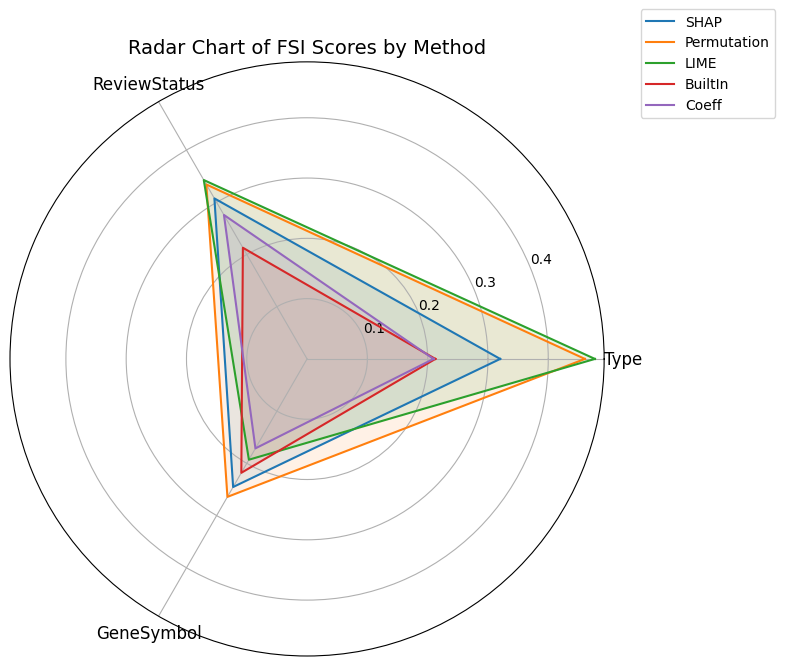

In [ ]:
from math import pi
fsi_data = {
    'SHAP': {'Type': 0.3203, 'ReviewStatus': 0.3074, 'GeneSymbol': 0.2453},
    'Permutation': {'Type': 0.4608, 'ReviewStatus': 0.3341, 'GeneSymbol': 0.2642},
    'LIME': {'Type': 0.4774, 'ReviewStatus': 0.3426, 'GeneSymbol': 0.1930},
    'BuiltIn': {'Type': 0.2128, 'ReviewStatus': 0.2129, 'GeneSymbol': 0.2181},
    'Coeff': {'Type': 0.2097, 'ReviewStatus': 0.2757, 'GeneSymbol': 0.1713}
}
fsi_df = pd.DataFrame(fsi_data).T
categories = list(fsi_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for method in fsi_df.index:
    values = fsi_df.loc[method].tolist()
    values += values[:1]
    ax.plot(angles, values, label=method)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_title('Radar Chart of FSI Scores by Method', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

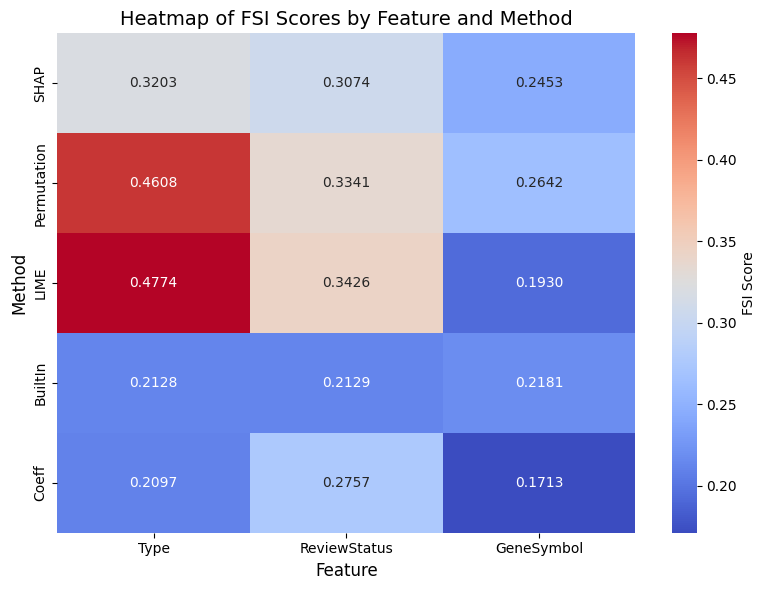

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(fsi_df, annot=True, cmap='coolwarm', fmt='.4f', cbar_kws={'label': 'FSI Score'})
plt.title('Heatmap of FSI Scores by Feature and Method', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Method', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
fsi_final = {
    'Type': {'Mean Importance': 0.3669, 'Std Dev': 0.3554, 'FSI Score': 0.2707},
    'ReviewStatus': {'Mean Importance': 0.2977, 'Std Dev': 0.3194, 'FSI Score': 0.2256},
    'GeneSymbol': {'Mean Importance': 0.2254, 'Std Dev': 0.3215, 'FSI Score': 0.1706}
}

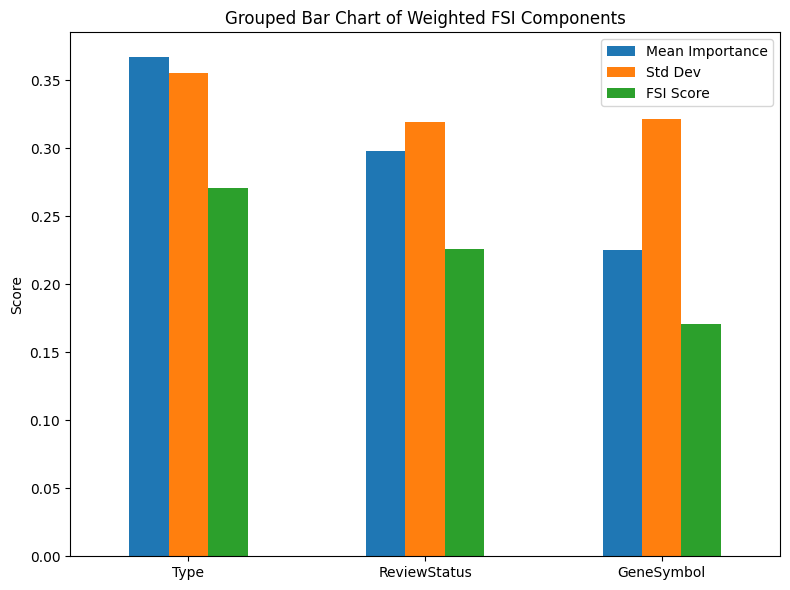

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
fsi_df = pd.DataFrame(fsi_final).T
fsi_df.plot(kind='bar', figsize=(8, 6))
plt.title('Grouped Bar Chart of Weighted FSI Components')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

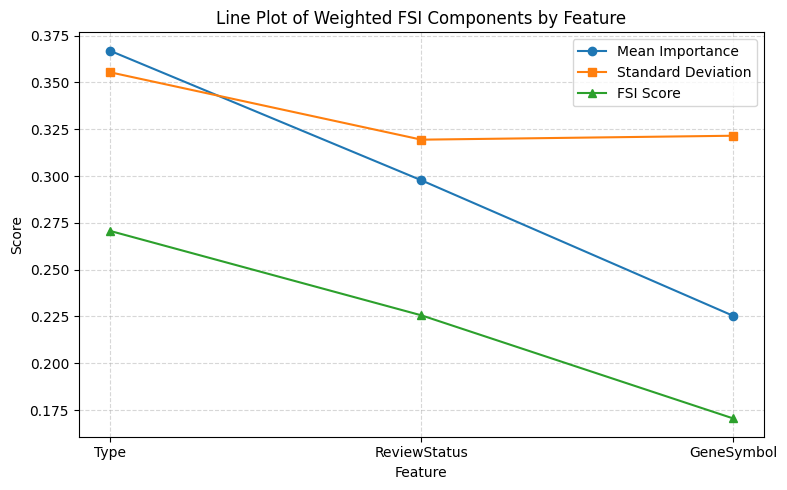

In [ ]:
fsi_df = pd.DataFrame(fsi_final).T
plt.figure(figsize=(8, 5))
plt.plot(fsi_df.index, fsi_df['Mean Importance'], marker='o', label='Mean Importance')
plt.plot(fsi_df.index, fsi_df['Std Dev'], marker='s', label='Standard Deviation')
plt.plot(fsi_df.index, fsi_df['FSI Score'], marker='^', label='FSI Score')
plt.title('Line Plot of Weighted FSI Components by Feature')
plt.ylabel('Score')
plt.xlabel('Feature')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

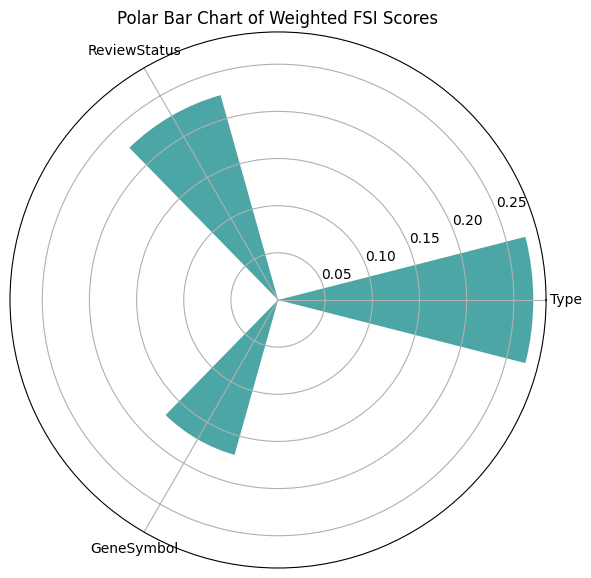

In [ ]:
categories = list(fsi_df.index)
values = fsi_df['FSI Score'].tolist()
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
values += values[:1]
angles += angles[:1]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
bars = ax.bar(angles[:-1], fsi_df['FSI Score'], width=0.5, color='teal', alpha=0.7)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Polar Bar Chart of Weighted FSI Scores')
plt.tight_layout()
plt.show()

# **SHAP EXPLAINABILITY for RANDOM FOREST**

Summary Plot (Bar Plot) - Shows the mean absolute SHAP value for each feature (global feature importance).

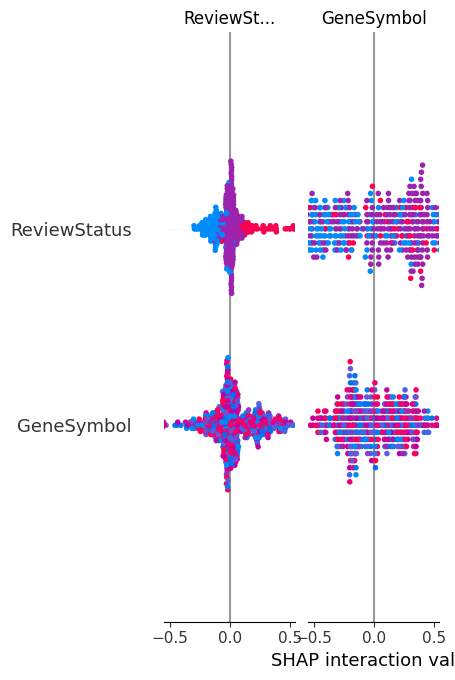

In [ ]:
shap.summary_plot(shap_values_rf_class1, X_test_sample, feature_names=features)

Summary Plot (Beeswarm Plot) - Shows the distribution of SHAP values for each feature and how they relate to feature values.

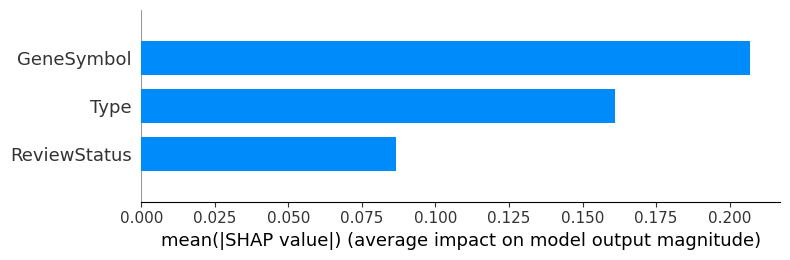

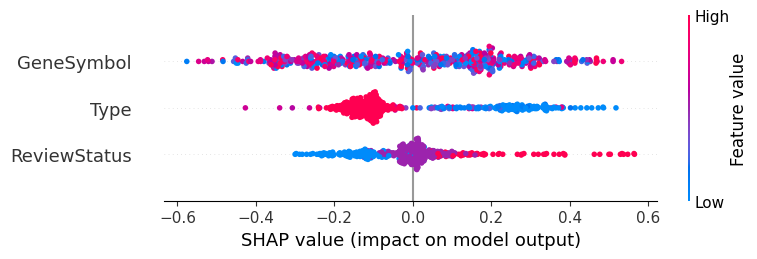

In [ ]:
# Bar plot (global feature importance)
shap.summary_plot(shap_values_class1_fixed, X_test_sample, plot_type="bar")

# Beeswarm plot (distribution + feature values)
shap.summary_plot(shap_values_class1_fixed, X_test_sample)

Force Plots - Visualize the prediction for individual instances.

In [ ]:
# Force plot for one instance (e.g., first row)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_class1_fixed[0], X_test_sample.iloc[0])

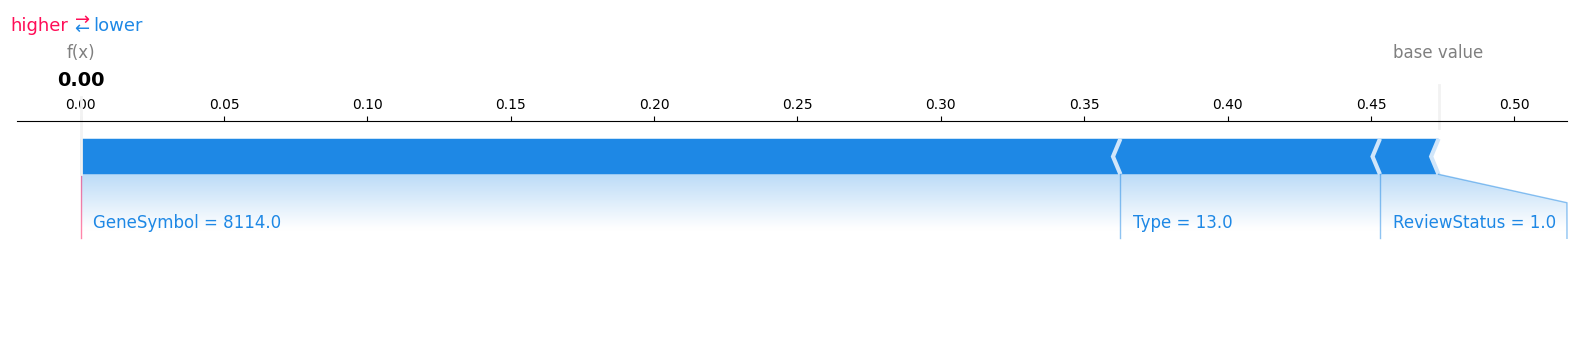

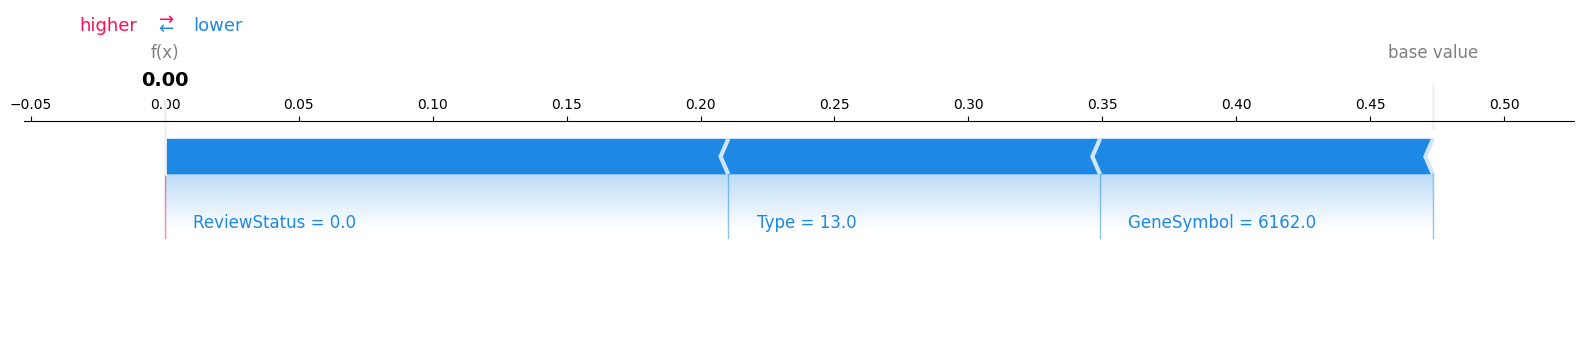

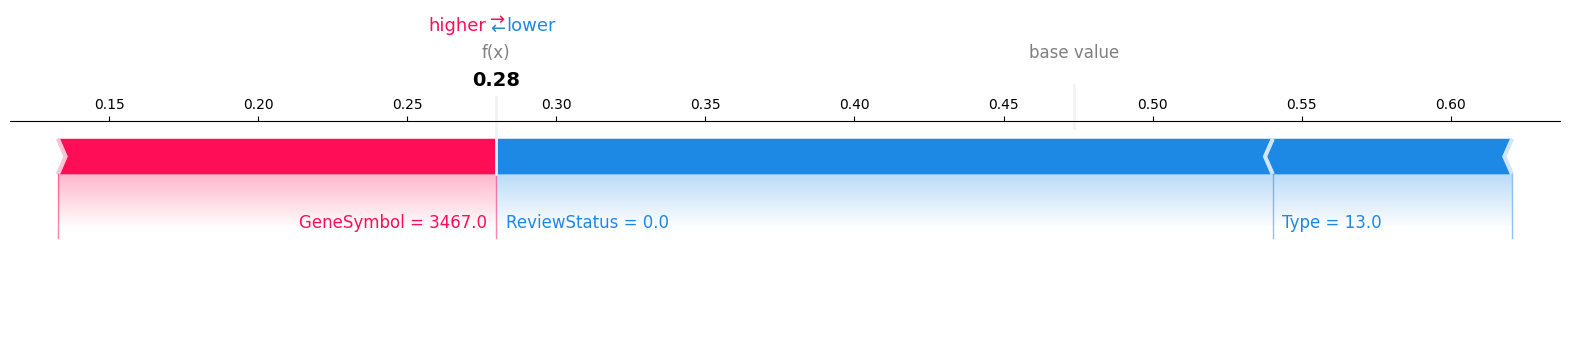

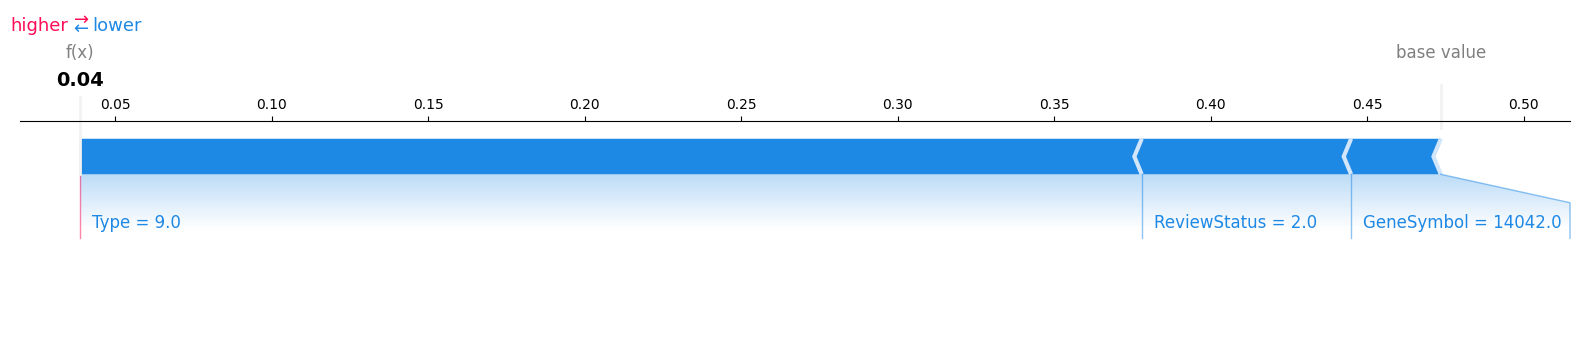

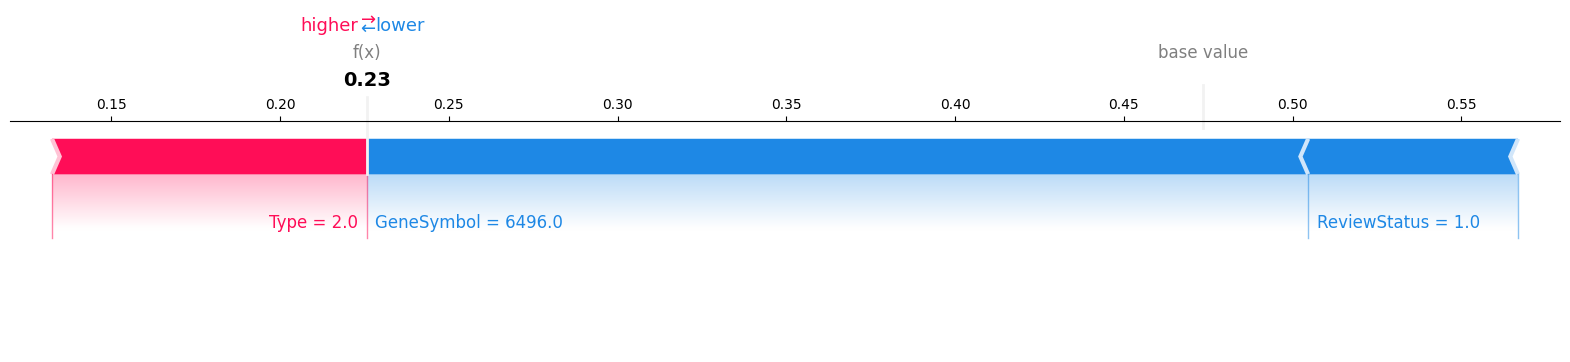

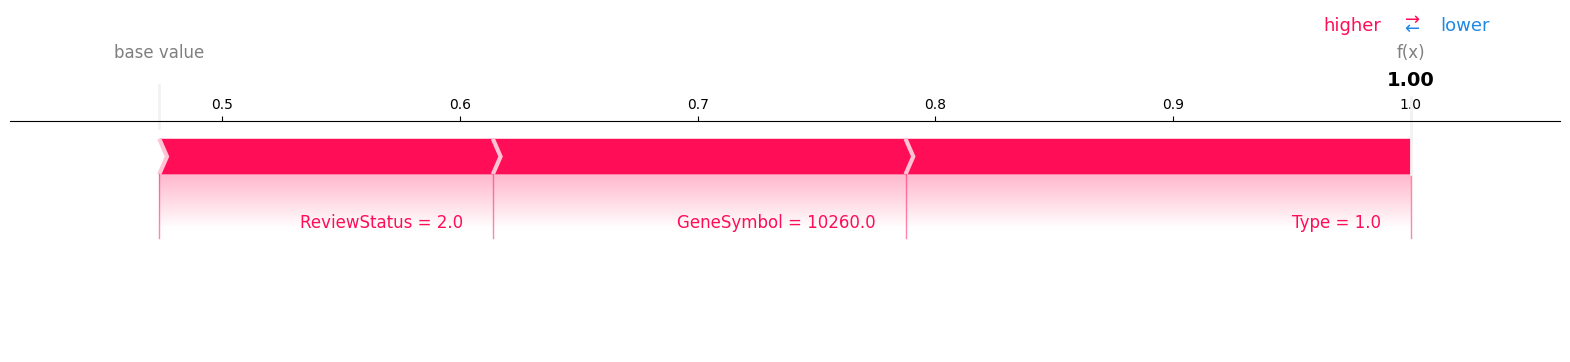

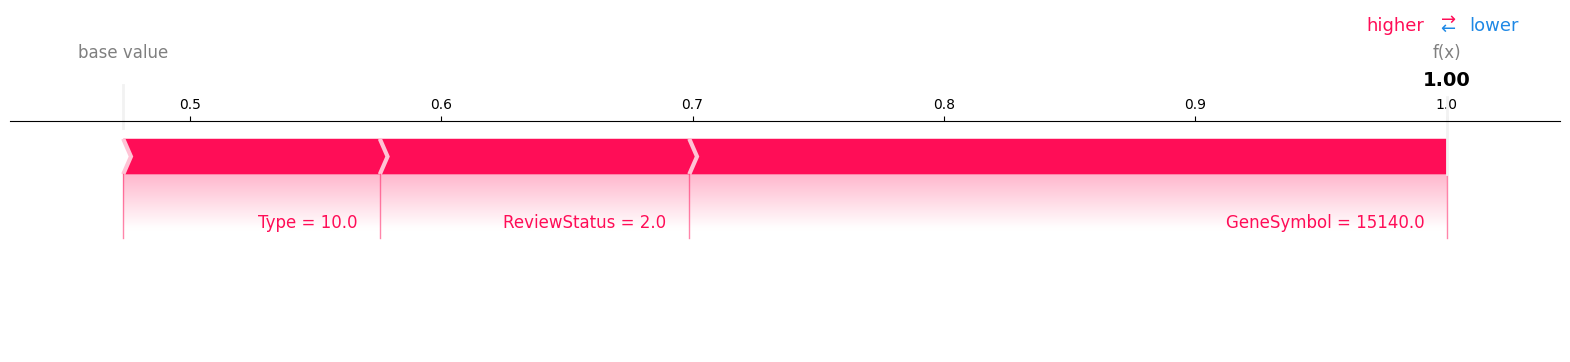

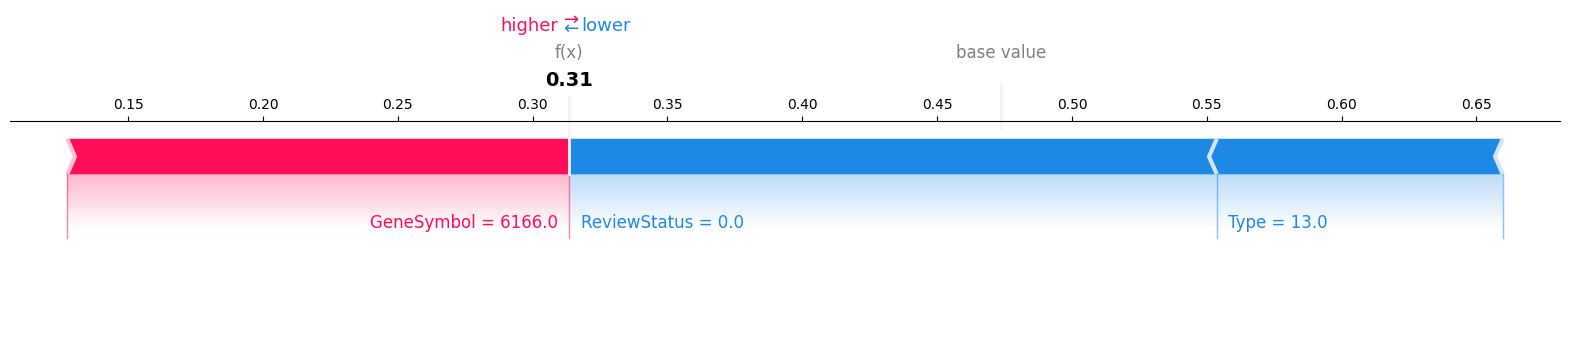

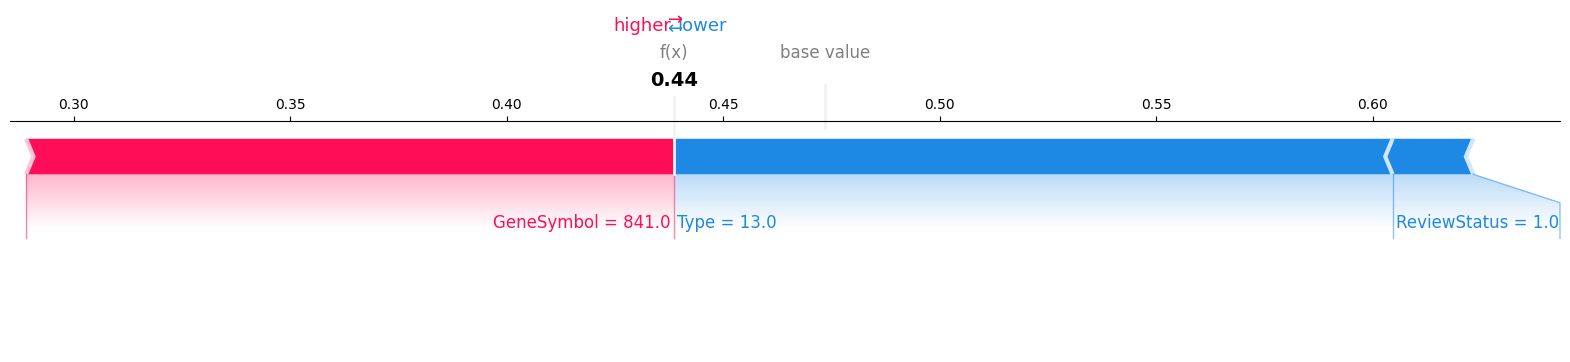

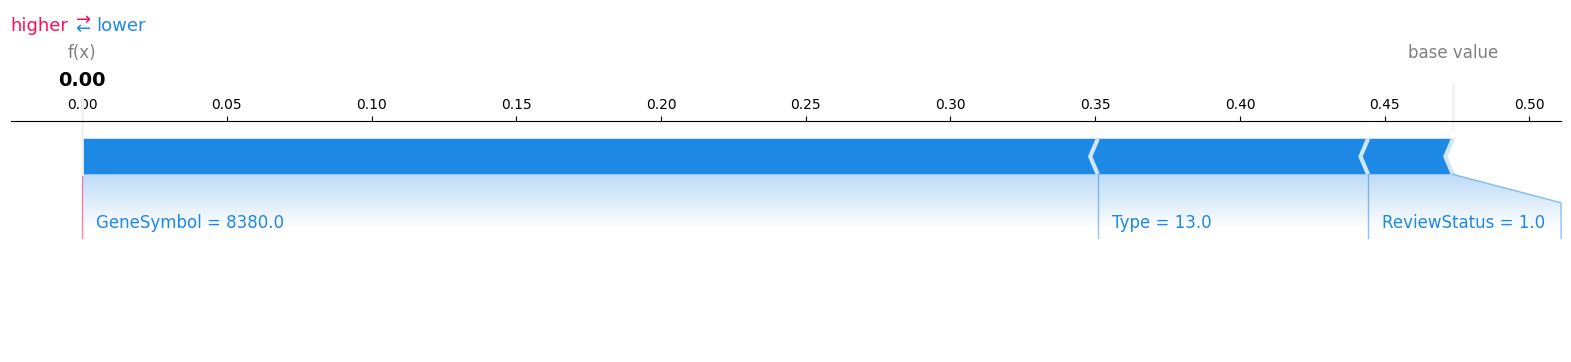

In [ ]:
import shap

# Initialize JS for interactive plots
shap.initjs()

# Loop through first 10 rows
for i in range(10):
    shap.force_plot(
        explainer_rf.expected_value[1],
        shap_values_class1_fixed[i],
        X_test_sample.iloc[i],
        matplotlib=True  # Use matplotlib backend for inline display
    )

Dependence Plots - Show how a single feature affects the model's predictions.

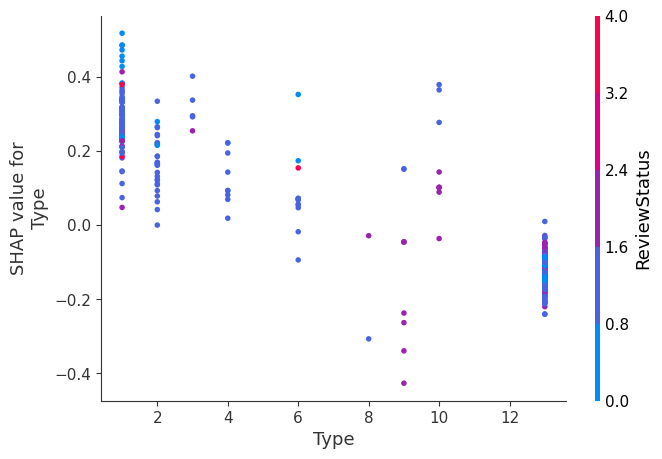

In [ ]:
# Replace "Type" with any feature name from your dataset
shap.dependence_plot("Type", shap_values_class1_fixed, X_test_sample)

Waterfall Plots - Show the cumulative effect of features for a single prediction.

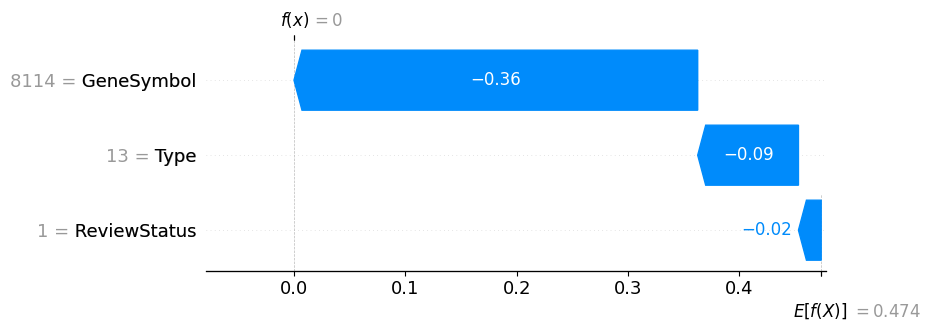

In [ ]:
shap.plots.waterfall(shap.Explanation(values=shap_values_class1_fixed[0],
                                      base_values=explainer_rf.expected_value[1],
                                      data=X_test_sample.iloc[0],
                                      feature_names=features))

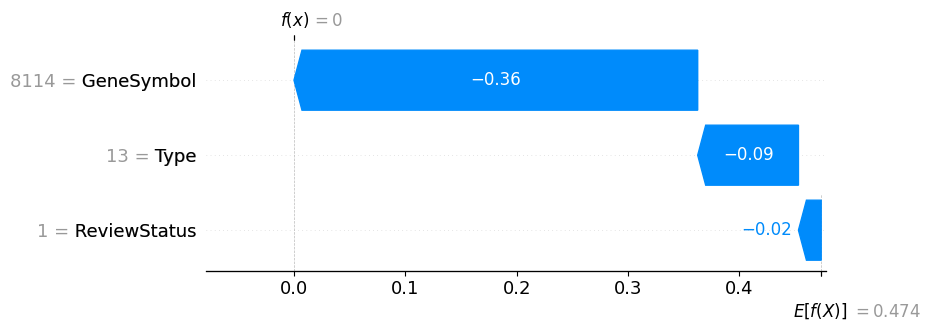

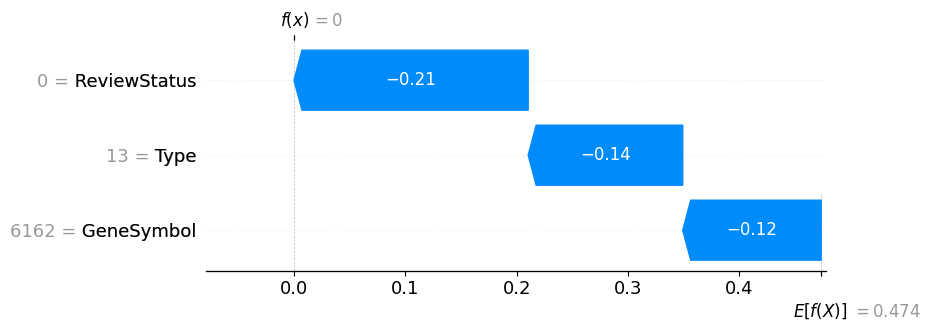

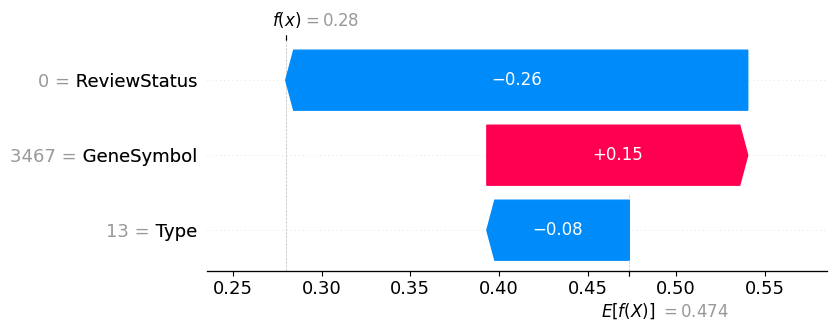

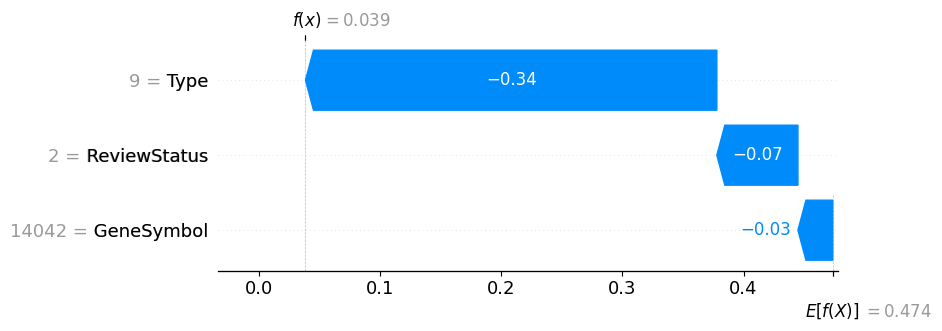

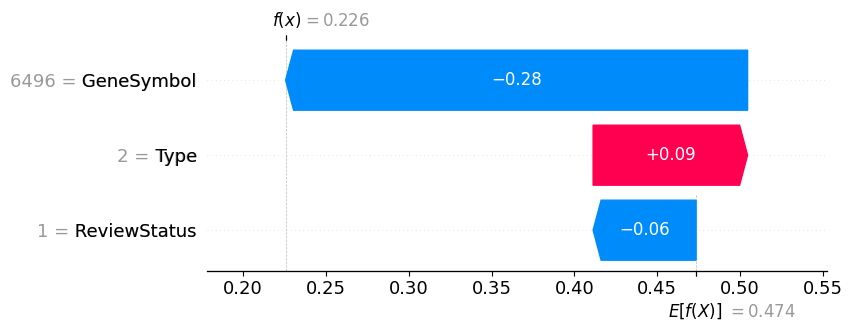

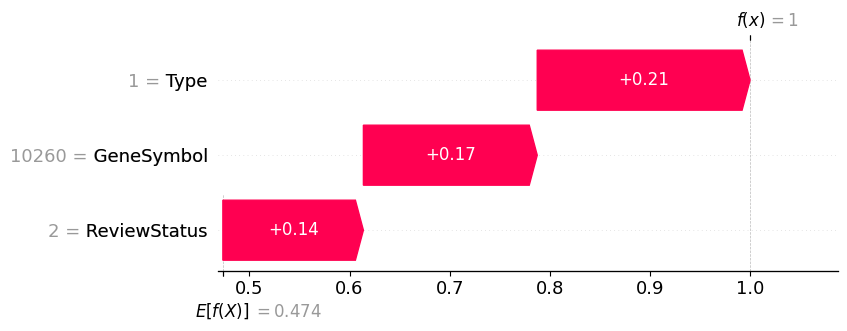

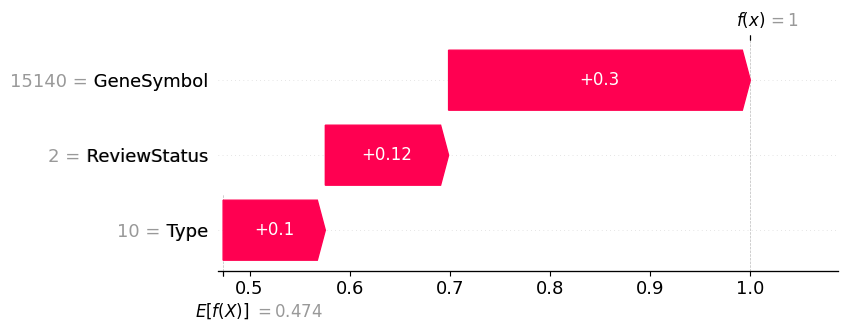

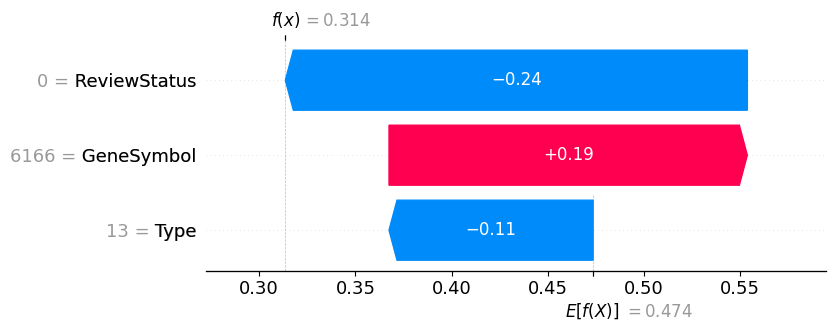

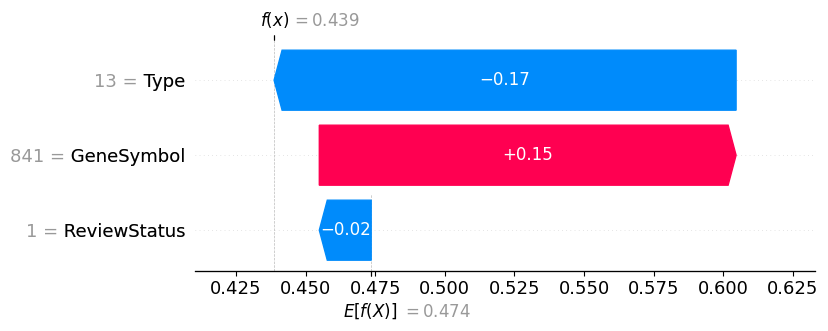

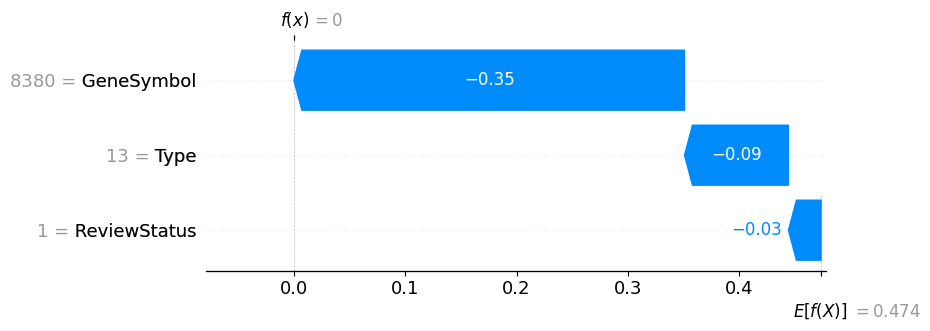

In [ ]:
for i in range(10):
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values_class1_fixed[i],
            base_values=explainer_rf.expected_value[1],
            data=X_test_sample.iloc[i],
            feature_names=features
        )
    )

Statistical Summary- Provide statistical insights from SHAP values.

In [ ]:
import numpy as np
shap_mean = np.mean(shap_values_class1_fixed, axis=0)
shap_std = np.std(shap_values_class1_fixed, axis=0)
stats_df = pd.DataFrame({
    "Feature": features,
    "SHAP_Mean": shap_mean,
    "SHAP_StdDev": shap_std
}).sort_values(by="SHAP_Mean", ascending=False)
print("SHAP Statistical Summary:")
print(stats_df)

SHAP Statistical Summary:
        Feature  SHAP_Mean  SHAP_StdDev
1  ReviewStatus  -0.002328     0.132495
0    GeneSymbol  -0.005063     0.241459
2          Type  -0.008291     0.183621


SHAP Summary Plot – Feature Impact Overview
Shows how each feature influences the model’s predictions and direction of impact.

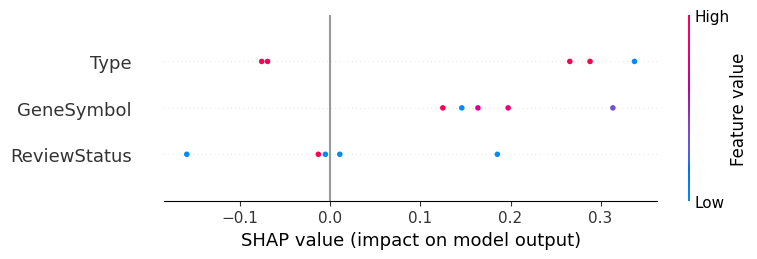

In [ ]:
sample_indices = np.random.choice(len(shap_values_class1_fixed), size=5, replace=False)
shap_values_sample = shap_values_class1_fixed[sample_indices]
X_sample = X_test.iloc[sample_indices]
shap.summary_plot(shap_values_sample, X_sample, feature_names=features)

SHAP Decision Plot – Cumulative Feature Contributions
Visualizes how features combine step-by-step to push predictions for individual samples.

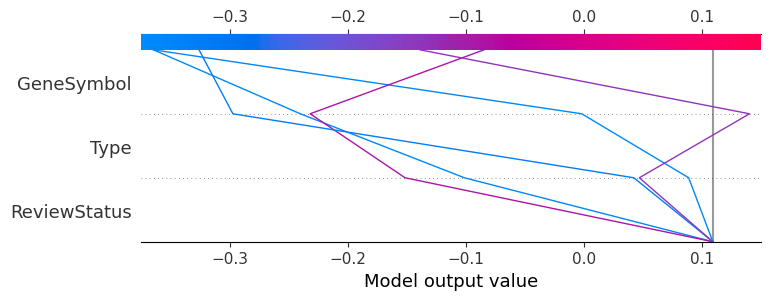

In [ ]:
shap.decision_plot(
    explainer_rf.expected_value[1],
    shap_values_class1_fixed[:5],
    X_test_sample.iloc[:5],
    feature_names=features
)

SHAP Heatmap – Feature Value Correlations
Displays how SHAP values of different features co-vary, helping identify feature redundancy or interaction.

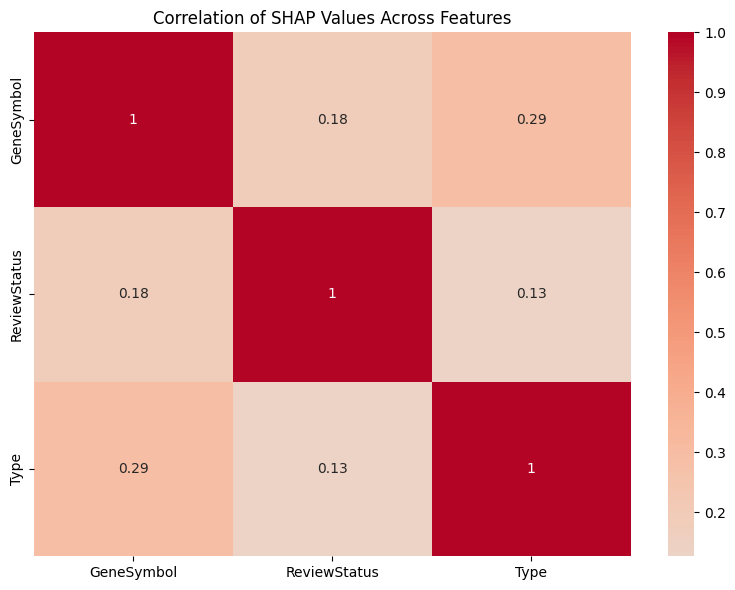

In [ ]:
shap_df = pd.DataFrame(shap_values_class1_fixed, columns=features)
corr_matrix = shap_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of SHAP Values Across Features")
plt.tight_layout()
plt.show()

LIME

In [ ]:
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Benign', 'Pathogenic'],
    mode='classification',
    training_labels=y_train,
    random_state=42,
    discretize_continuous=True )

In [ ]:
instance_indices = [0, 10, 50]
for idx in instance_indices:
    instance = X_test.iloc[idx].values
    true_label = y_test.iloc[idx]
    pred_label = rf_model.predict(instance.reshape(1, -1))[0]
    pred_proba = rf_model.predict_proba(instance.reshape(1, -1))[0]
    print(f"\n=== Explaining Instance {idx} ===")
    print(f"True label: {true_label} ({'Benign' if true_label == 0 else 'Pathogenic'})")
    print(f"Predicted label: {pred_label} ({'Benign' if pred_label == 0 else 'Pathogenic'})")
    print(f"Prediction probabilities: Benign={pred_proba[0]:.3f}, Pathogenic={pred_proba[1]:.3f}")
    exp = explainer_lime.explain_instance(
        data_row=instance,
        predict_fn=rf_model.predict_proba,
        num_features=len(features),
        top_labels=1
    )
    exp.show_in_notebook(show_table=True)
    exp.save_to_file(f'lime_explanation_instance_{idx}.html')


=== Explaining Instance 0 ===
True label: Benign (Pathogenic)
Predicted label: Pathogenic (Pathogenic)
Prediction probabilities: Benign=0.292, Pathogenic=0.708



=== Explaining Instance 10 ===
True label: Benign (Pathogenic)
Predicted label: Benign (Pathogenic)
Prediction probabilities: Benign=1.000, Pathogenic=0.000



=== Explaining Instance 50 ===
True label: Pathogenic (Pathogenic)
Predicted label: Pathogenic (Pathogenic)
Prediction probabilities: Benign=0.094, Pathogenic=0.906


# ***MANY FEATURE TO BINARY CLASSIFICATION***

In [ ]:
file_path = "variant_summary.txt.gz"
columns = ["VariationID", "GeneSymbol", "ClinicalSignificance", "ReviewStatus", "Type"]
df = pd.read_csv(file_path, sep="\t", usecols=columns)
major_classes = ['Pathogenic', 'Benign']
df_binary = df[df['ClinicalSignificance'].isin(major_classes)]

min_count = df_binary['ClinicalSignificance'].value_counts().min()
df_binary_balanced = (
    df_binary.groupby("ClinicalSignificance", group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
)

print(df_binary_balanced['ClinicalSignificance'].value_counts())
print(df_binary_balanced.head())

features = ['GeneSymbol', 'ReviewStatus', 'Type']
X = df_binary[features].fillna("Unknown")
for col in features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

y = df_binary['ClinicalSignificance']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

ClinicalSignificance
Benign        384422
Pathogenic    384422
Name: count, dtype: int64
                              Type GeneSymbol ClinicalSignificance  \
2227413  single nucleotide variant       BRK1               Benign   
4990939  single nucleotide variant     SETBP1               Benign   
322632   single nucleotide variant       PEX1               Benign   
2179899  single nucleotide variant      PPM1D               Benign   
1102369  single nucleotide variant      EIF3B               Benign   

                                              ReviewStatus  VariationID  
2227413                criteria provided, single submitter      1292409  
4990939                criteria provided, single submitter      2779777  
322632   criteria provided, multiple submitters, no con...       256221  
2179899                criteria provided, single submitter      1268529  
1102369                criteria provided, single submitter       768132  
